# **New PatchTST 1**

## **Model Training**

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# import os
# csv_path = "/content/drive/MyDrive/FYP/FYP-WF-7/Rextro/1-RAW_HOURLY_DATA/"
# os.makedirs(csv_path, exist_ok=True)

In [3]:
# !pip uninstall -y transformers accelerate


In [4]:
!pip install -U "transformers>=4.40.0" "accelerate>=0.27.0"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 62.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.2
    Uninstalling transformers-4.57.2:
      Successfully uninstalled transformers-4.57.2


In [5]:
# !pip install -q transformers accelerate scikit-learn pandas matplotlib

import os
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from transformers import (
    PatchTSTConfig,
    PatchTSTForPrediction,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt

# Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(transformers.__version__)


In [6]:
# Add this NEW CELL after imports, before data loading

import torch.nn.functional as F

class VariancePreservingLoss(torch.nn.Module):
    """
    Custom loss that combines prediction accuracy with variance preservation.
    """
    def __init__(self, alpha=0.1, beta=0.1):
        super().__init__()
        self.alpha = alpha  # Weight for MAE loss
        self.beta = beta    # Weight for variance penalty

    def forward(self, predictions, targets):
        # predictions: (batch, horizon, features)
        # targets: (batch, horizon, features)

        # 1. Main prediction loss (MAE)
        mae_loss = F.l1_loss(predictions, targets)

        # 2. Variance preservation loss
        # Calculate variance along time dimension for each feature
        pred_var = torch.var(predictions, dim=1)  # (batch, features)
        target_var = torch.var(targets, dim=1)    # (batch, features)

        # Penalize when predicted variance is lower than target variance
        variance_loss = F.mse_loss(pred_var, target_var)

        # 3. Total loss
        total_loss = self.alpha * mae_loss + self.beta * variance_loss

        return total_loss

# Initialize the custom loss
custom_loss_fn = VariancePreservingLoss(alpha=1.0, beta=0.3)

In [7]:
# Paths
csv_path = "/content/drive/MyDrive/FYP/FYP-WF-7/Rextro/1-RAW_HOURLY_DATA/secondly_sensor_dataset.csv"
df = pd.read_csv(csv_path)

feature_cols = df.columns[:6].tolist()
assert len(feature_cols) == 6, f"Expected 6 features, got {len(feature_cols)}"

data = df[feature_cols].values.astype(np.float32)  # shape: (70000, 6)



STEP 1: RAW DATA VISUALIZATION


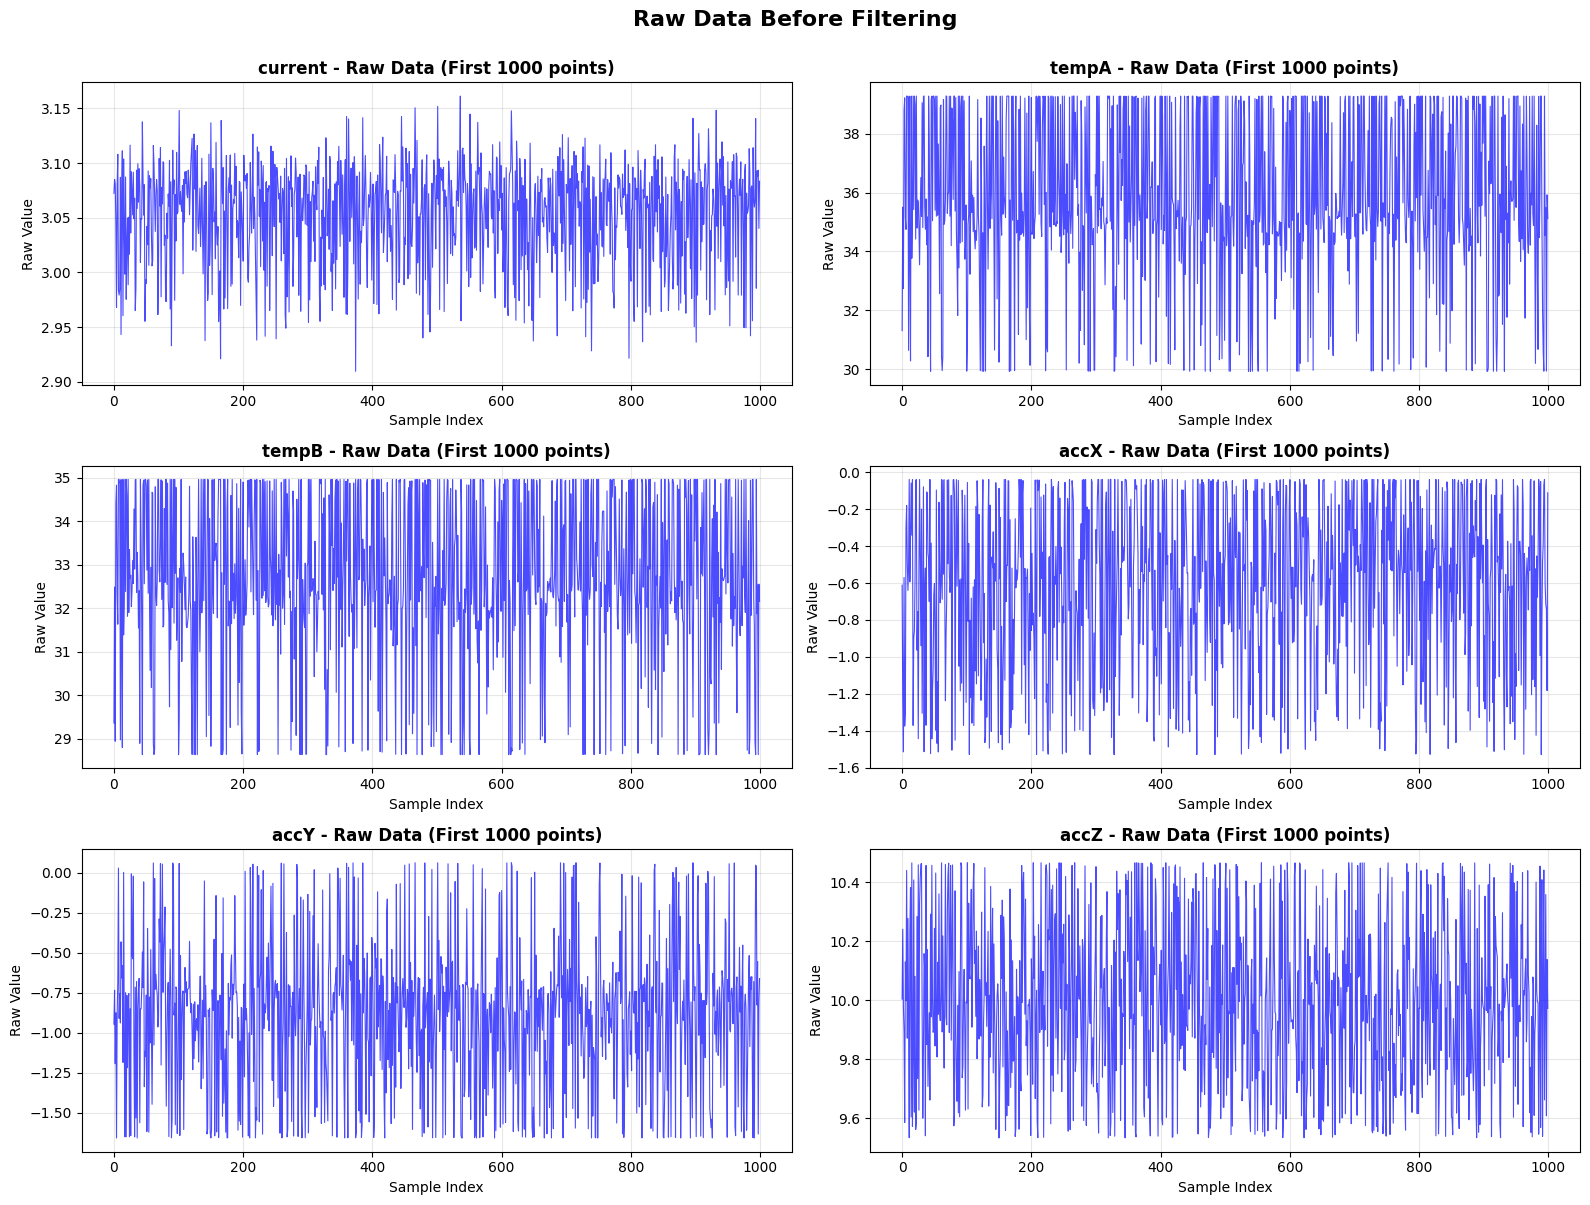


Raw Data Statistics:
            current         tempA         tempB          accX          accY  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean       3.052468     35.802582     32.621166     -0.630529     -0.876602   
std        0.045570      2.903402      1.975363      0.448592      0.471033   
min        2.879390     29.925766     28.634251     -1.529681     -1.659035   
25%        3.023494     34.452456     31.771748     -0.973518     -1.179648   
50%        3.061650     35.471142     32.588675     -0.575312     -0.824595   
75%        3.084927     39.109660     34.727789     -0.229025     -0.657216   
max        3.220423     39.278481     34.958920     -0.038114      0.062255   

               accZ  
count  70000.000000  
mean      10.007896  
std        0.278603  
min        9.532913  
25%        9.804321  
50%        9.993853  
75%       10.214506  
max       10.466479  


In [8]:
# ✅ STEP 1: VISUALIZE RAW DATA (Before Filtering)
print("\n" + "="*80)
print("STEP 1: RAW DATA VISUALIZATION")
print("="*80)

# Plot raw data for all features
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(feature_cols):
    ax = axes[i]
    # Plot first 1000 points (or all if less)
    plot_points = min(1000, len(data))
    ax.plot(range(plot_points), data[:plot_points, i],
            color='blue', alpha=0.7, linewidth=0.8)
    ax.set_title(f'{col} - Raw Data (First {plot_points} points)',
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Raw Value')
    ax.grid(True, alpha=0.3)

plt.suptitle('Raw Data Before Filtering', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Print statistics
print(f"\nRaw Data Statistics:")
print(pd.DataFrame(data, columns=feature_cols).describe())


STEP 1.5: OUTLIER REMOVAL
Using Z-score method for outlier removal (threshold=3.0)...

📊 Outlier Removal Statistics:
   current        :    100 outliers removed (0.14%)
   tempA          :      0 outliers removed (0.00%)
   tempB          :      0 outliers removed (0.00%)
   accX           :      0 outliers removed (0.00%)
   accY           :      0 outliers removed (0.00%)
   accZ           :      0 outliers removed (0.00%)

   Total outliers removed: 100 (0.0238% of all data)


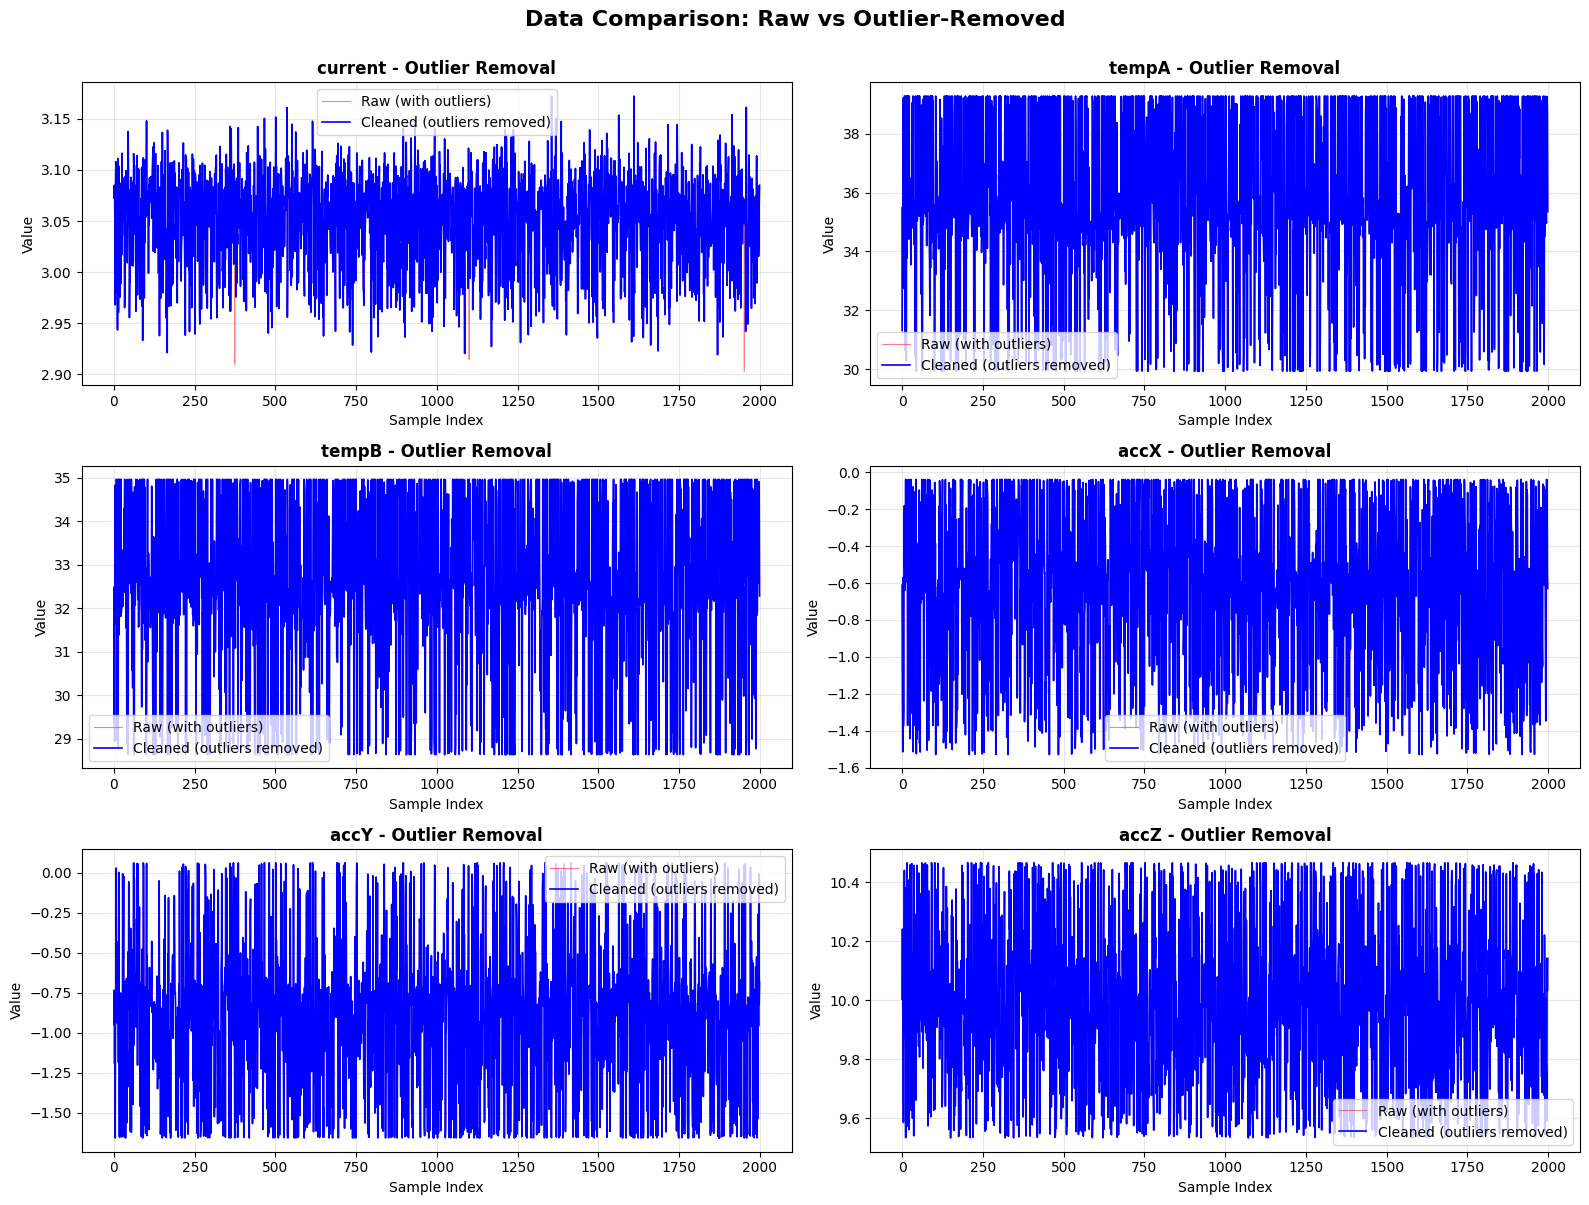

/tmp/ipython-input-1953880271.py:101: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot([data[:, i] for i in range(len(feature_cols))], labels=feature_cols)
/tmp/ipython-input-1953880271.py:109: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot([data_no_outliers[:, i] for i in range(len(feature_cols))], labels=feature_cols)


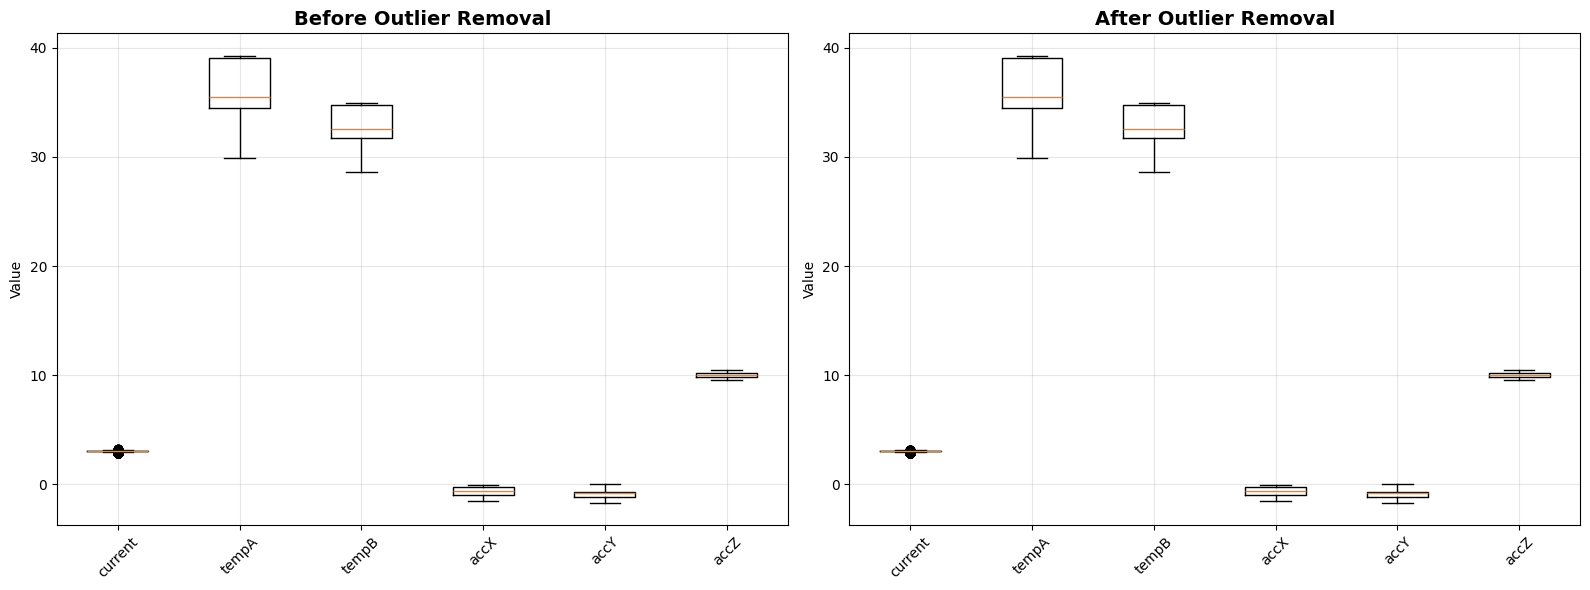


✅ Outlier removal complete! Data shape: (70000, 6)
   'data' variable updated for subsequent processing steps.


In [9]:
# ✅ STEP 1.5: REMOVE OUTLIERS (Before Filtering)
print("\n" + "="*80)
print("STEP 1.5: OUTLIER REMOVAL")
print("="*80)

def remove_outliers_zscore(data, threshold=3.0):
    """
    Remove outliers using Z-score method.
    Replaces outliers with interpolated values.

    Parameters:
    -----------
    data : numpy array
        Input data (N, features)
    threshold : float
        Z-score threshold (3.0 = 99.7% of data retained)

    Returns:
    --------
    data_cleaned : numpy array
        Data with outliers replaced by interpolated values
    outlier_counts : list
        Number of outliers per feature
    """
    data_cleaned = data.copy()
    outlier_counts = []

    for col_idx in range(data.shape[1]):
        col_data = data[:, col_idx]

        # Calculate Z-scores
        mean = np.mean(col_data)
        std = np.std(col_data)
        z_scores = np.abs((col_data - mean) / std)

        # Identify outliers
        outlier_mask = z_scores > threshold
        num_outliers = np.sum(outlier_mask)
        outlier_counts.append(num_outliers)

        # Replace outliers with NaN, then interpolate
        if num_outliers > 0:
            col_cleaned = col_data.copy()
            col_cleaned[outlier_mask] = np.nan

            # Linear interpolation to fill NaN values
            nans = np.isnan(col_cleaned)
            x = np.arange(len(col_cleaned))
            col_cleaned[nans] = np.interp(x[nans], x[~nans], col_cleaned[~nans])

            data_cleaned[:, col_idx] = col_cleaned

    return data_cleaned, outlier_counts


# Z-score method (better for normally distributed data)
print("Using Z-score method for outlier removal (threshold=3.0)...")
data_no_outliers, outlier_counts = remove_outliers_zscore(data, threshold=3.0)

# Print outlier statistics
print(f"\n📊 Outlier Removal Statistics:")
total_outliers = 0
for i, col in enumerate(feature_cols):
    pct = (outlier_counts[i] / len(data)) * 100
    total_outliers += outlier_counts[i]
    print(f"   {col:15s}: {outlier_counts[i]:6d} outliers removed ({pct:.2f}%)")

print(f"\n   Total outliers removed: {total_outliers} ({(total_outliers / data.size) * 100:.4f}% of all data)")

# ✅ VISUALIZATION: Compare raw vs cleaned data
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

plot_points = min(2000, len(data))

for i, col in enumerate(feature_cols):
    ax = axes[i]

    # Plot raw and cleaned data
    ax.plot(range(plot_points), data[:plot_points, i],
            label='Raw (with outliers)', alpha=0.5, linewidth=0.8, color='red')
    ax.plot(range(plot_points), data_no_outliers[:plot_points, i],
            label='Cleaned (outliers removed)', linewidth=1.2, color='blue')

    ax.set_title(f'{col} - Outlier Removal', fontsize=12, fontweight='bold')
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Value')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.suptitle('Data Comparison: Raw vs Outlier-Removed',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# ✅ Box plot comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Before outlier removal
ax1 = axes[0]
ax1.boxplot([data[:, i] for i in range(len(feature_cols))], labels=feature_cols)
ax1.set_title('Before Outlier Removal', fontsize=14, fontweight='bold')
ax1.set_ylabel('Value')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# After outlier removal
ax2 = axes[1]
ax2.boxplot([data_no_outliers[:, i] for i in range(len(feature_cols))], labels=feature_cols)
ax2.set_title('After Outlier Removal', fontsize=14, fontweight='bold')
ax2.set_ylabel('Value')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ✅ Update data variable for subsequent steps
data = data_no_outliers
print(f"\n✅ Outlier removal complete! Data shape: {data.shape}")
print("   'data' variable updated for subsequent processing steps.")

In [10]:
# ✅ STEP 2: APPLY BUTTERWORTH FILTER
print("\n" + "="*80)
print("STEP 2: APPLYING BUTTERWORTH LOW-PASS FILTER")
print("="*80)

from scipy.signal import butter, filtfilt

def butterworth_filter(data, cutoff_freq=0.1, order=4, fs=1.0):
    """
    Apply Butterworth low-pass filter to remove high-frequency noise

    Parameters:
    -----------
    data : array
        Input signal
    cutoff_freq : float
        Cutoff frequency (normalized, 0 to 1)
    order : int
        Filter order (higher = sharper cutoff)
    fs : float
        Sampling frequency
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data, axis=0)
    return filtered_data

# Apply Butterworth filter to all features
print("Filtering data with Butterworth low-pass filter...")
print(f"Parameters: cutoff_freq=0.1, order=4")

# data_filtered = butterworth_filter(data, cutoff_freq=0.1, order=4)
data_filtered = butterworth_filter(data, cutoff_freq=0.3, order=2)

print(f"✅ Filtering complete!")
print(f"Original data shape: {data.shape}")
print(f"Filtered data shape: {data_filtered.shape}")


STEP 2: APPLYING BUTTERWORTH LOW-PASS FILTER
Filtering data with Butterworth low-pass filter...
Parameters: cutoff_freq=0.1, order=4
✅ Filtering complete!
Original data shape: (70000, 6)
Filtered data shape: (70000, 6)



STEP 3: FILTERED DATA VISUALIZATION


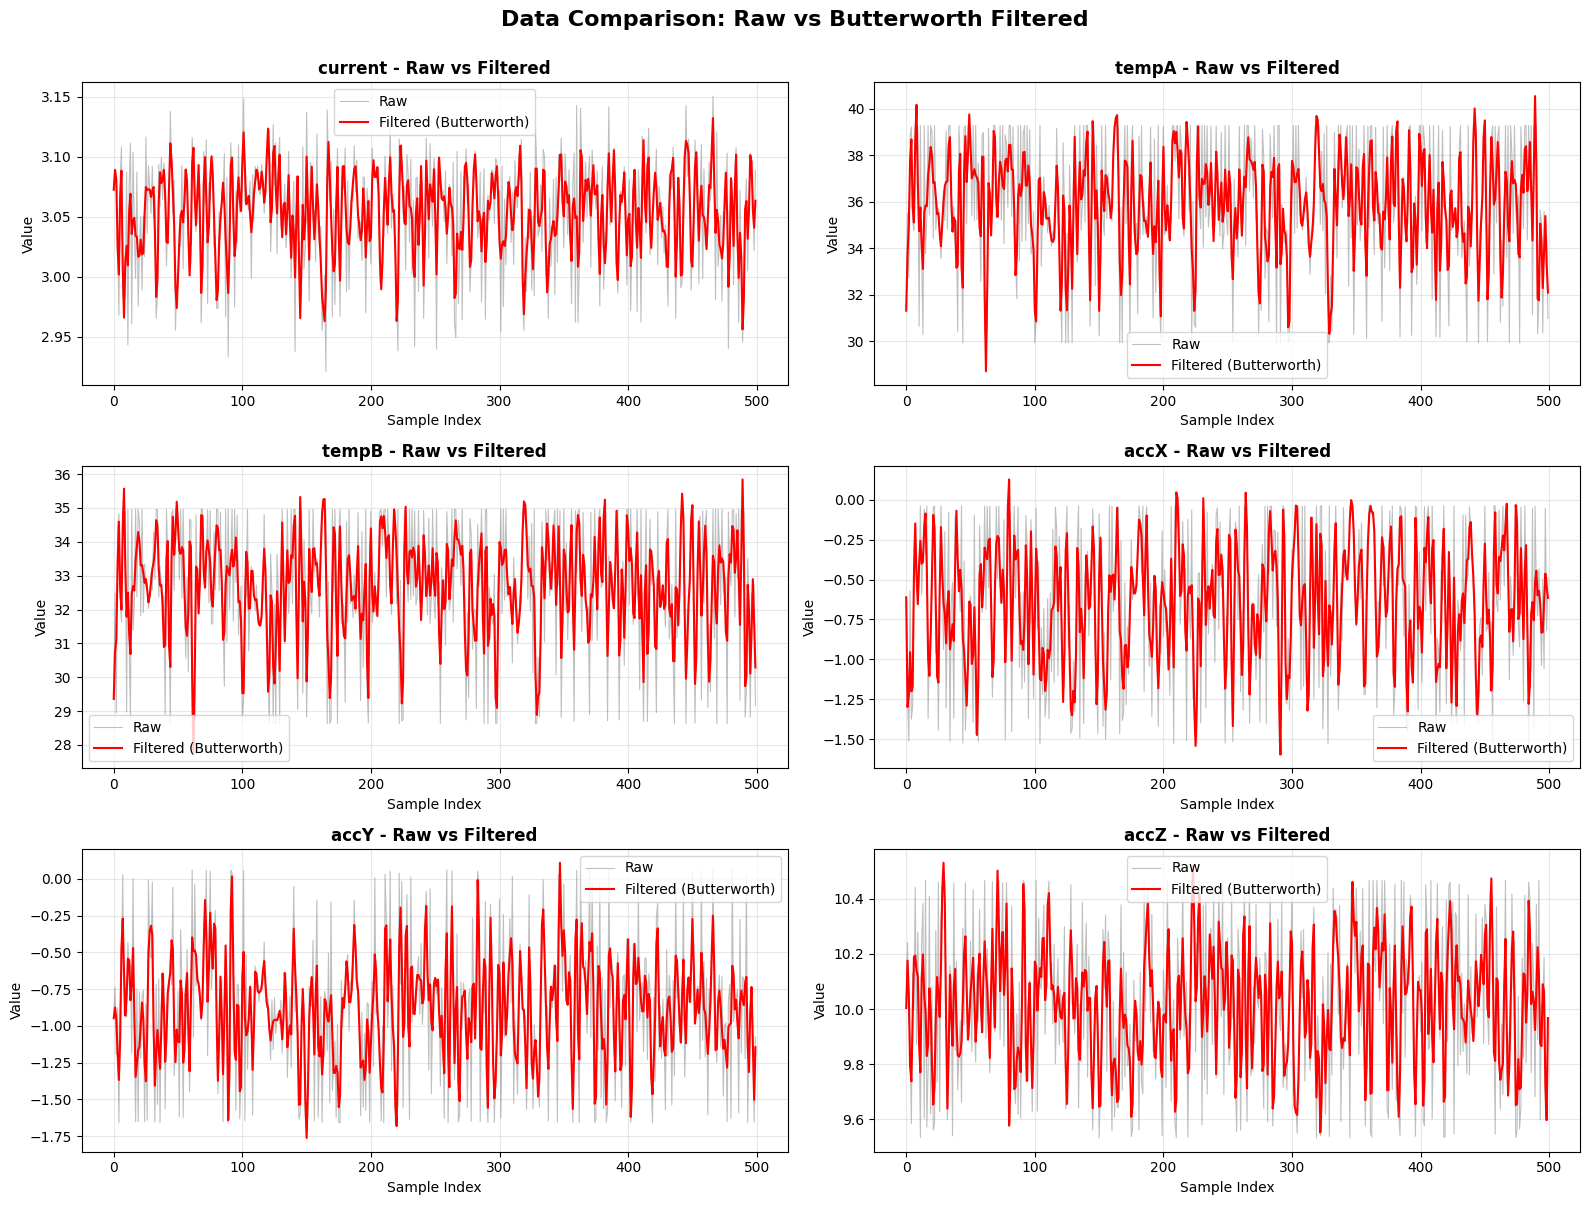


Filtered Data Statistics:
            current         tempA         tempB          accX          accY  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean       3.052586     35.802569     32.621158     -0.630528     -0.876600   
std        0.032578      2.093385      1.426009      0.324257      0.340593   
min        2.924243     28.335984     27.567325     -1.733494     -1.920879   
25%        3.031193     34.408253     31.675415     -0.861048     -1.110757   
50%        3.055714     35.932471     32.756875     -0.611687     -0.871215   
75%        3.076139     37.330644     33.660505     -0.386884     -0.648576   
max        3.168198     40.827669     35.972118      0.189194      0.322174   

               accZ  
count  70000.000000  
mean      10.007897  
std        0.200877  
min        9.408363  
25%        9.863970  
50%       10.005269  
75%       10.151726  
max       10.593275  

📊 Noise Reduction Metrics:
current        : SNR =  41.26 dB, N

In [11]:
# ✅ STEP 3: VISUALIZE FILTERED DATA (After Butterworth)
print("\n" + "="*80)
print("STEP 3: FILTERED DATA VISUALIZATION")
print("="*80)

# Plot filtered data comparison
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

plot_points = min(500, len(data))

for i, col in enumerate(feature_cols):
    ax = axes[i]
    # Plot raw and filtered data
    ax.plot(range(plot_points), data[:plot_points, i],
            label='Raw', alpha=0.5, linewidth=0.8, color='gray')
    ax.plot(range(plot_points), data_filtered[:plot_points, i],
            label='Filtered (Butterworth)', linewidth=1.5, color='red')

    ax.set_title(f'{col} - Raw vs Filtered', fontsize=12, fontweight='bold')
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Value')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.suptitle('Data Comparison: Raw vs Butterworth Filtered',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Print filtered data statistics
print(f"\nFiltered Data Statistics:")
print(pd.DataFrame(data_filtered, columns=feature_cols).describe())

# Calculate noise reduction metrics
print(f"\n📊 Noise Reduction Metrics:")
for i, col in enumerate(feature_cols):
    noise = data[:, i] - data_filtered[:, i]
    noise_power = np.mean(noise ** 2)
    signal_power = np.mean(data_filtered[:, i] ** 2)

    if noise_power > 0:
        snr = 10 * np.log10(signal_power / noise_power)
        print(f"{col:15s}: SNR = {snr:6.2f} dB, Noise Std = {np.std(noise):.6f}")
    else:
        print(f"{col:15s}: SNR = inf dB (no noise)")

Selected feature column names: ['current', 'tempA', 'tempB', 'accX', 'accY', 'accZ']
Original data shape: (70000, 6)
Scaled data shape: (70000, 6)

STEP 1: RAW DATA (First 500 rows)
      current      tempA      tempB      accX      accY       accZ
0    3.072412  31.308254  29.361810 -0.611175 -0.947172  10.003816
1    3.085011  35.501930  32.486140 -1.219518 -0.735054  10.241150
2    3.080827  32.737510  28.941797 -1.514636 -1.194515   9.977747
3    3.043865  38.794760  34.395947 -0.569786 -0.876418   9.893091
4    2.968022  39.218906  34.827217 -1.374995 -1.659023   9.585499
..        ...        ...        ...       ...       ...        ...
495  3.102870  30.351850  28.820837 -0.494513 -0.922652   9.986017
496  3.091484  35.568370  32.481945 -1.059116 -0.765471  10.187580
497  3.065451  34.362644  32.044900 -0.052133 -1.014195   9.637597
498  3.021602  34.483020  32.731525 -0.820875 -1.656258   9.636648
499  3.088625  30.976210  29.165735 -0.489854 -1.075913   9.914554

[500 rows x 6

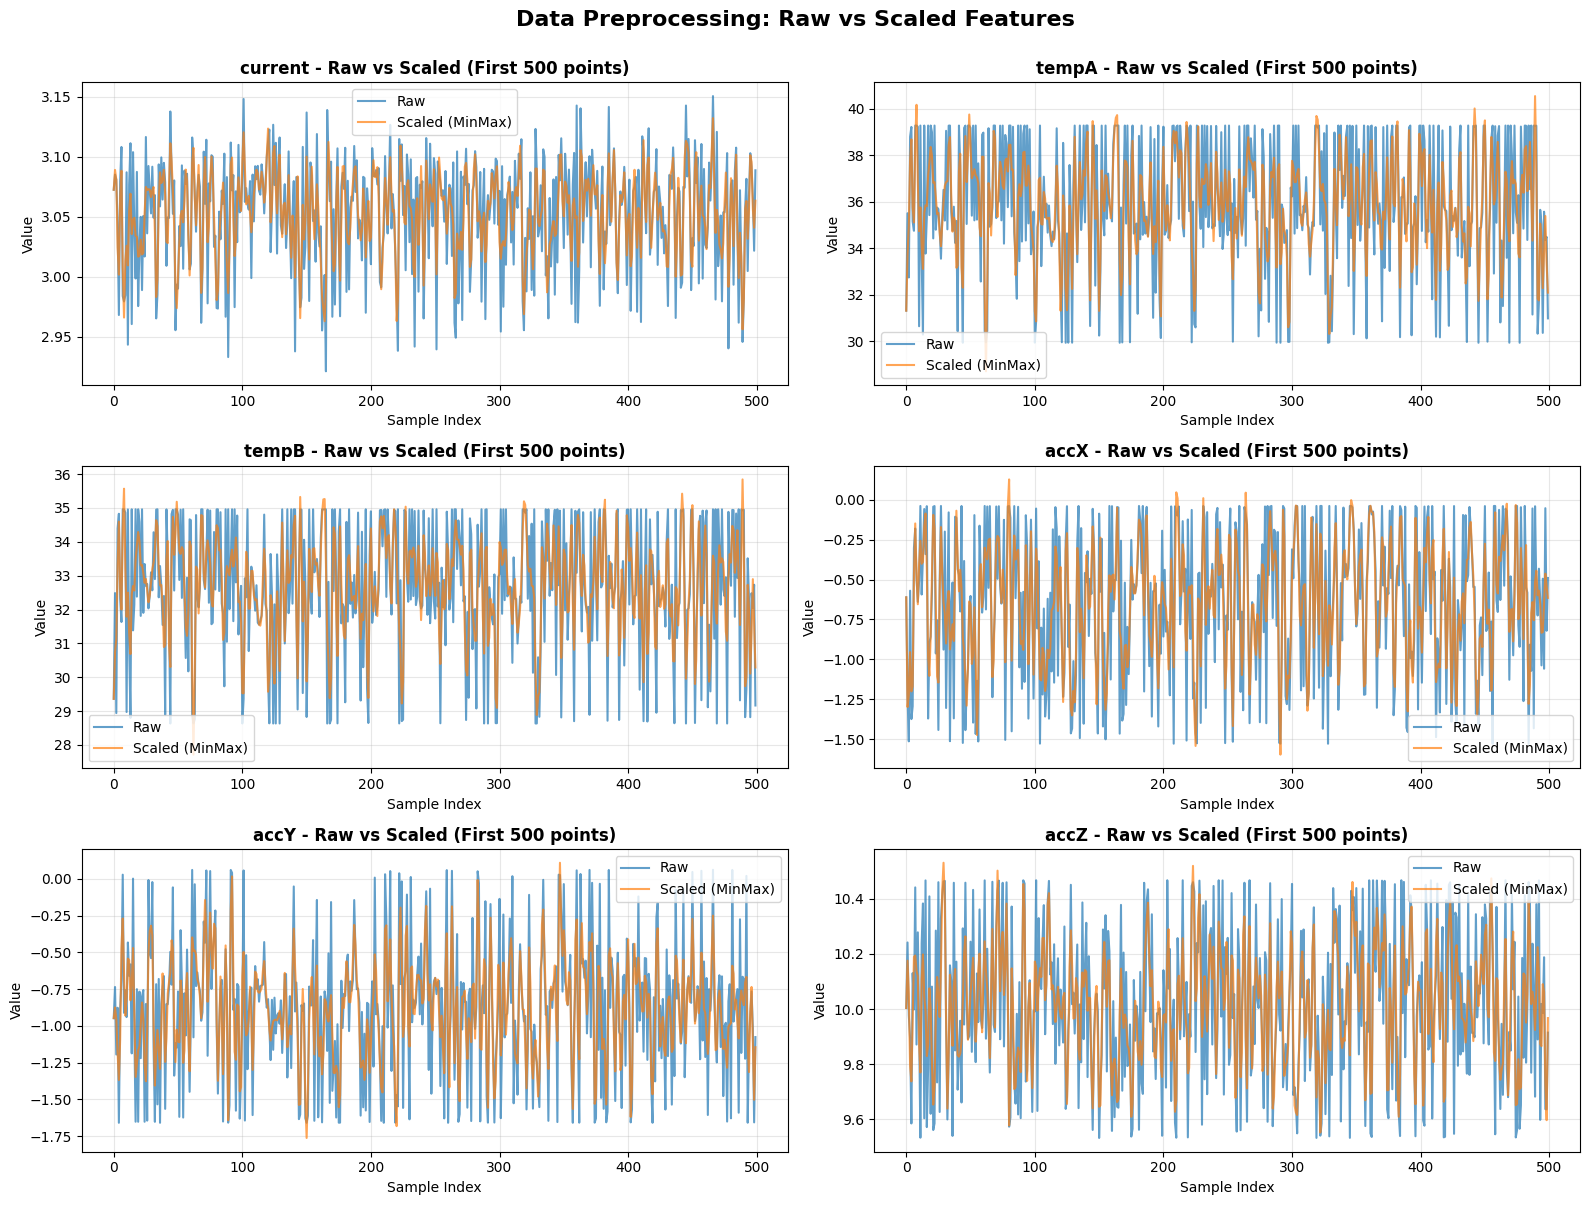


✅ Data loading and scaling complete!



In [12]:
# ============================================

# ✅ OPTION 1: StandardScaler with feature-wise scaling
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# data_scaled = scaler.fit_transform(data_filtered).astype(np.float32)
# print("✅ Applied StandardScaler to filtered data")
# print(f"Scaled mean: {data_scaled.mean():.6f} (should be ~0)")
# print(f"Scaled std: {data_scaled.std():.6f} (should be ~1)")


# ============================================
# REPLACE your scaling cell with this:
# ============================================

# from sklearn.preprocessing import StandardScaler

# # ✅ STEP 1: Apply StandardScaler to filtered data
# print("\n" + "="*80)
# print("APPLYING STANDARDSCALER TO FILTERED DATA")
# print("="*80)

# scaler = StandardScaler()
# data_scaled = scaler.fit_transform(data_filtered).astype(np.float32)

# print(f"✅ StandardScaler applied")
# print(f"   Original data range: min={data_filtered.min():.4f}, max={data_filtered.max():.4f}")
# print(f"   Scaled data range: min={data_scaled.min():.4f}, max={data_scaled.max():.4f}")
# print(f"   Scaled mean (should be ~0): {data_scaled.mean():.6f}")
# print(f"   Scaled std (should be ~1): {data_scaled.std():.6f}")

# # ✅ Per-feature check
# print(f"\n📊 Per-feature statistics after scaling:")
# for i, col in enumerate(feature_cols):
#     col_data = data_scaled[:, i]
#     print(f"   {col:10s}: mean={col_data.mean():+.4f}, std={col_data.std():.4f}, "
#           f"min={col_data.min():+.4f}, max={col_data.max():+.4f}")

# ============================================
# REPLACE your scaling cell with this:
# ============================================



# ✅ OPTION 2: No scaling (let model learn raw patterns)
scaler = None
data_scaled = data_filtered.astype(np.float32)






# Print full shape and column names
print("Selected feature column names:", feature_cols)
print("Original data shape:", data.shape)
print("Scaled data shape:", data_scaled.shape)

# ✅ STEP 1: Print first 500 data points (RAW DATA)
print("\n" + "="*80)
print("STEP 1: RAW DATA (First 500 rows)")
print("="*80)
print(df[feature_cols].head(500))
print(f"\nRaw data statistics:\n{df[feature_cols].describe()}")

# ✅ STEP 2: Print first 500 data points (SCALED DATA)
print("\n" + "="*80)
print("STEP 2: SCALED DATA (First 500 rows)")
print("="*80)
df_scaled = pd.DataFrame(data_scaled[:500], columns=feature_cols)
print(df_scaled)
print(f"\nScaled data statistics:\n{df_scaled.describe()}")

# ✅ VISUALIZATION: Plot raw vs scaled data
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(feature_cols):
    ax = axes[i]
    # Plot first 500 points
    ax.plot(data[:500, i], label='Raw', alpha=0.7, linewidth=1.5)
    ax.plot(data_scaled[:500, i], label='Scaled (MinMax)', alpha=0.7, linewidth=1.5)
    ax.set_title(f'{col} - Raw vs Scaled (First 500 points)', fontweight='bold')
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Data Preprocessing: Raw vs Scaled Features', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n✅ Data loading and scaling complete!\n")


Train windows: (52201, 240, 6) (52201, 60, 6)
Val windows: (10201, 240, 6) (10201, 60, 6)
Test windows: (6701, 240, 6) (6701, 60, 6)

STEP 3: TRAIN/VAL/TEST SPLITS (First 500 samples from each)

Train series shape: (52500, 6)
Train series (first 500 rows):
      current      tempA      tempB      accX      accY       accZ
0    3.072423  31.307182  29.361080 -0.611141 -0.947197  10.003751
1    3.088928  33.699371  30.745577 -1.299301 -0.874534  10.175323
2    3.080722  34.982254  31.119013 -1.226339 -0.954272  10.053980
3    3.024362  37.786198  33.317627 -0.955246 -1.183350   9.793116
4    3.001657  38.683910  34.595585 -1.201390 -1.367960   9.737933
..        ...        ...        ...       ...       ...        ...
495  3.101227  32.277687  30.109322 -0.829120 -0.900200  10.089957
496  3.095683  33.899849  31.319523 -0.639905 -0.734812  10.062637
497  3.056367  35.384083  32.896210 -0.462846 -1.134070   9.730302
498  3.040785  33.317242  31.585190 -0.545480 -1.502322   9.597395
499  3

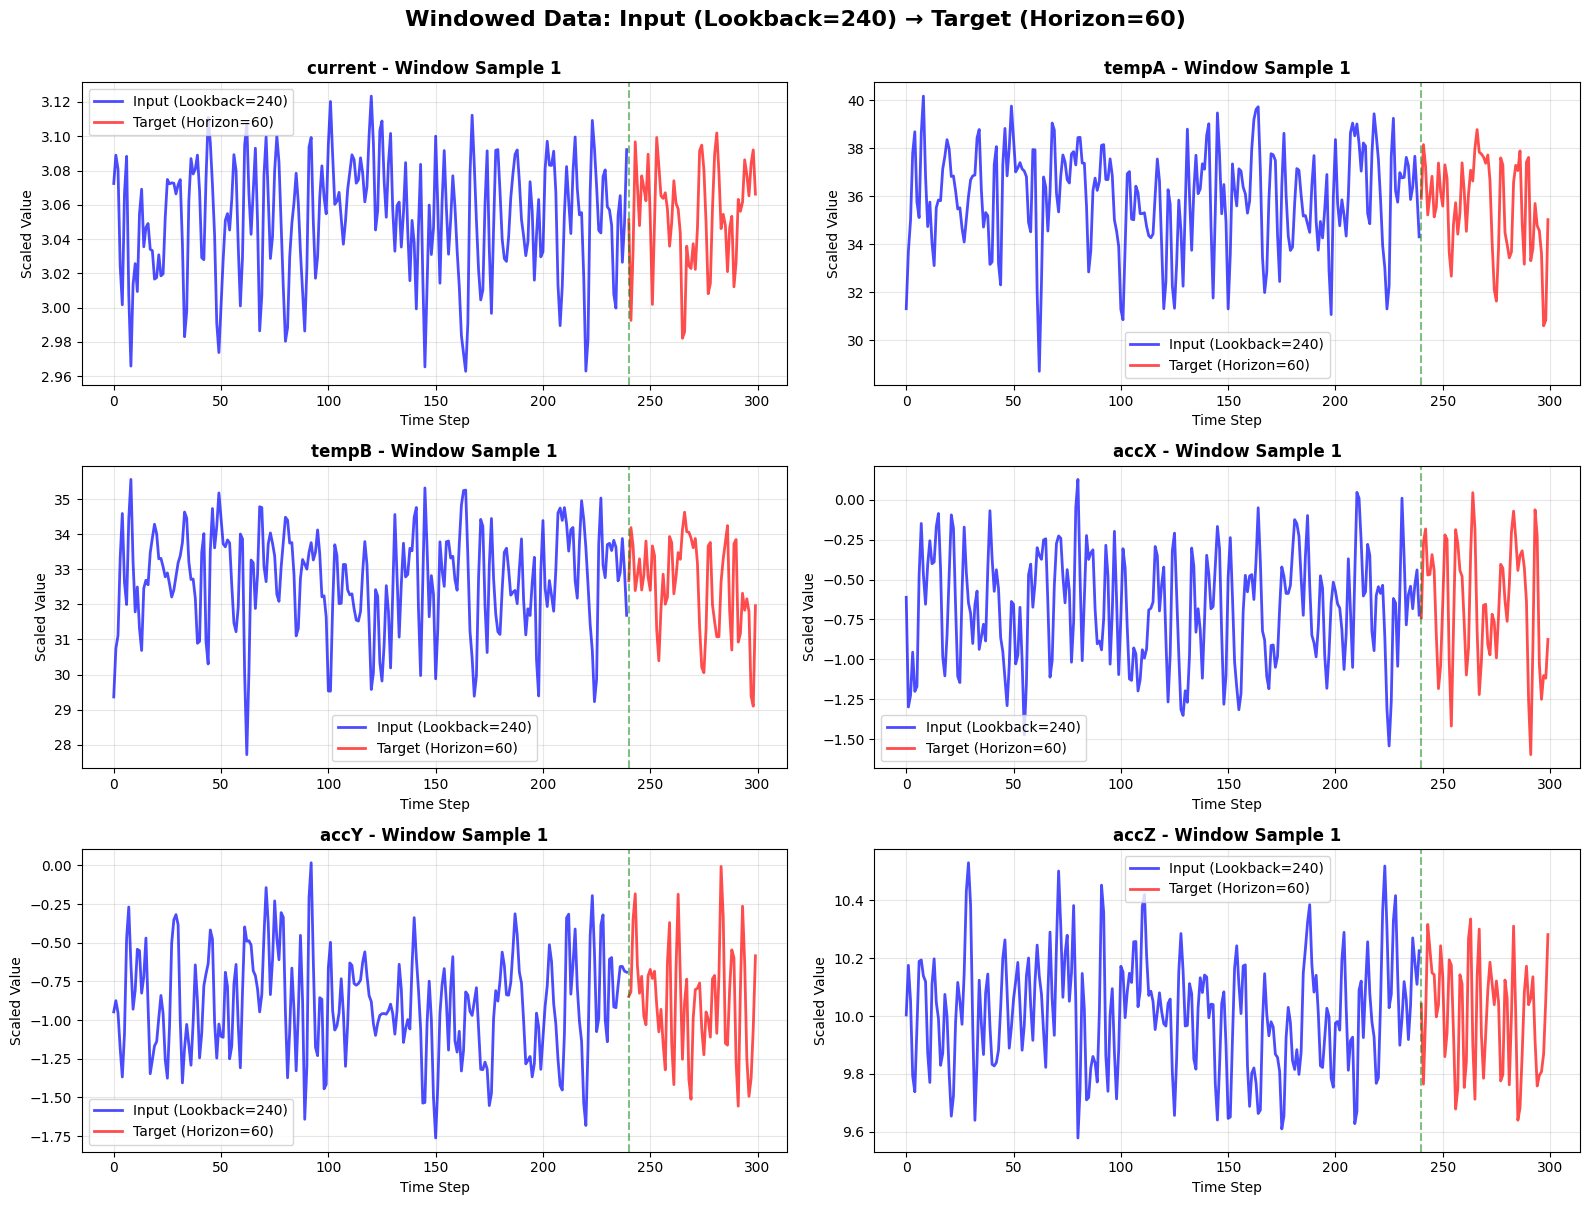


✅ Data windowing complete!


In [13]:
# Hyperparameters
context_length = 240        # lookback window
prediction_length = 60      # forecast horizon
num_features = data_scaled.shape[1]  # 6

# Splits (75/15/15)
N = data_scaled.shape[0]
n_train = int(0.75 * N)
n_val = int(0.15 * N)
train_series = data_scaled[:n_train]
val_series   = data_scaled[n_train:n_train + n_val]
test_series  = data_scaled[n_train + n_val:]

def build_windows(arr, context_len, pred_len):
    X_list, Y_list = [], []
    T = arr.shape[0]
    for start in range(0, T - context_len - pred_len + 1):
        end_ctx = start + context_len
        end_pred = end_ctx + pred_len
        X_list.append(arr[start:end_ctx])      # (context_len, C)
        Y_list.append(arr[end_ctx:end_pred])   # (pred_len, C)
    X = np.stack(X_list, axis=0) if X_list else np.empty((0, context_len, arr.shape[1]), dtype=np.float32)
    Y = np.stack(Y_list, axis=0) if Y_list else np.empty((0, pred_len, arr.shape[1]), dtype=np.float32)
    return X.astype(np.float32), Y.astype(np.float32)

X_train_np, y_train_np = build_windows(train_series, context_length, prediction_length)
X_val_np,   y_val_np   = build_windows(val_series,   context_length, prediction_length)
X_test_np,  y_test_np  = build_windows(test_series,  context_length, prediction_length)

print("Train windows:", X_train_np.shape, y_train_np.shape)
print("Val windows:",   X_val_np.shape,   y_val_np.shape)
print("Test windows:",  X_test_np.shape,  y_test_np.shape)

# ✅ STEP 3: Print first 500 samples from train/val/test splits
print("\n" + "="*80)
print("STEP 3: TRAIN/VAL/TEST SPLITS (First 500 samples from each)")
print("="*80)
print(f"\nTrain series shape: {train_series.shape}")
print(f"Train series (first 500 rows):\n{pd.DataFrame(train_series[:500], columns=feature_cols)}")
print(f"\nVal series shape: {val_series.shape}")
print(f"Val series (first 500 rows):\n{pd.DataFrame(val_series[:500], columns=feature_cols)}")
print(f"\nTest series shape: {test_series.shape}")
print(f"Test series (first 500 rows):\n{pd.DataFrame(test_series[:500], columns=feature_cols)}")

# ✅ STEP 4: Print windowed data samples
print("\n" + "="*80)
print("STEP 4: WINDOWED DATA (First 5 windows)")
print("="*80)
print(f"\nX_train (input windows) - First 5 windows:")
# for i in range(min(5, len(X_train_np))):
#     print(f"\nWindow {i+1} shape: {X_train_np[i].shape}")
#     print(f"First 10 timesteps:\n{pd.DataFrame(X_train_np[i][:10], columns=feature_cols)}")
#     print(f"Last 10 timesteps:\n{pd.DataFrame(X_train_np[i][-10:], columns=feature_cols)}")

# print(f"\ny_train (target windows) - First 5 windows:")
# for i in range(min(5, len(y_train_np))):
#     print(f"\nTarget {i+1} shape: {y_train_np[i].shape}")
#     print(f"All {prediction_length} target timesteps:\n{pd.DataFrame(y_train_np[i], columns=feature_cols)}")

# # ✅ VISUALIZATION: Plot train/val/test splits
# fig, axes = plt.subplots(3, 2, figsize=(16, 12))
# axes = axes.flatten()

# for i, col in enumerate(feature_cols):
#     ax = axes[i]
#     # Plot first 500 points from each split
#     train_plot = train_series[:500, i]
#     val_plot = val_series[:min(500, len(val_series)), i]
#     test_plot = test_series[:min(500, len(test_series)), i]

#     ax.plot(range(len(train_plot)), train_plot, label='Train', alpha=0.7, linewidth=1.5)
#     ax.plot(range(len(train_plot), len(train_plot) + len(val_plot)), val_plot,
#             label='Val', alpha=0.7, linewidth=1.5)
#     ax.plot(range(len(train_plot) + len(val_plot), len(train_plot) + len(val_plot) + len(test_plot)),
#             test_plot, label='Test', alpha=0.7, linewidth=1.5)

#     ax.set_title(f'{col} - Train/Val/Test Splits', fontweight='bold')
#     ax.set_xlabel('Sample Index')
#     ax.set_ylabel('Scaled Value')
#     ax.legend()
#     ax.grid(True, alpha=0.3)
#     ax.axvline(x=len(train_plot), color='red', linestyle='--', alpha=0.5)
#     ax.axvline(x=len(train_plot) + len(val_plot), color='orange', linestyle='--', alpha=0.5)

# plt.suptitle('Data Splits: Train (70%) / Val (15%) / Test (15%)', fontsize=16, fontweight='bold', y=1.00)
# plt.tight_layout()
# plt.show()

# ✅ VISUALIZATION: Sample windowed input-output pairs
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

sample_idx = 0  # First window
for i, col in enumerate(feature_cols):
    ax = axes[i]
    # Plot input window (context)
    input_window = X_train_np[sample_idx, :, i]
    target_window = y_train_np[sample_idx, :, i]

    ax.plot(range(context_length), input_window, label=f'Input (Lookback={context_length})',
            alpha=0.7, linewidth=2, color='blue')
    ax.plot(range(context_length, context_length + prediction_length), target_window,
            label=f'Target (Horizon={prediction_length})', alpha=0.7, linewidth=2, color='red')

    ax.set_title(f'{col} - Window Sample {sample_idx+1}', fontweight='bold')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Scaled Value')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axvline(x=context_length, color='green', linestyle='--', alpha=0.5, label='Forecast Start')

plt.suptitle(f'Windowed Data: Input (Lookback={context_length}) → Target (Horizon={prediction_length})',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n✅ Data windowing complete!")

In [14]:
model_paths = "/content/drive/MyDrive/FYP/FYP-WF-8/Rextro/Models/PatchTSTs/SET-2/V4/cusloss/"
os.makedirs(model_paths, exist_ok=True)

In [15]:
# ✅ SAVE WINDOWS TO DRIVE
print("\n" + "="*80)
print("SAVING WINDOWED DATA TO DRIVE")
print("="*80)

# Create directory for saving windows
windows_save_dir = os.path.join(model_paths, "smoothed_windows")
os.makedirs(windows_save_dir, exist_ok=True)

# Save training windows
np.save(os.path.join(windows_save_dir, "X_train.npy"), X_train_np)
np.save(os.path.join(windows_save_dir, "y_train.npy"), y_train_np)
print(f"✅ Saved training windows: X_train {X_train_np.shape}, y_train {y_train_np.shape}")

# Save validation windows
np.save(os.path.join(windows_save_dir, "X_val.npy"), X_val_np)
np.save(os.path.join(windows_save_dir, "y_val.npy"), y_val_np)
print(f"✅ Saved validation windows: X_val {X_val_np.shape}, y_val {y_val_np.shape}")

# Save test windows
np.save(os.path.join(windows_save_dir, "X_test.npy"), X_test_np)
np.save(os.path.join(windows_save_dir, "y_test.npy"), y_test_np)
print(f"✅ Saved test windows: X_test {X_test_np.shape}, y_test {y_test_np.shape}")

# Save metadata
metadata = {
    'context_length': context_length,
    'prediction_length': prediction_length,
    'num_features': num_features,
    'feature_cols': feature_cols,
    'train_windows': X_train_np.shape[0],
    'val_windows': X_val_np.shape[0],
    'test_windows': X_test_np.shape[0],
}

import json
with open(os.path.join(windows_save_dir, "metadata.json"), "w") as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Saved metadata to metadata.json")




# # ✅ Saving the Scaler Object
# import pickle
# scaler_path = os.path.join(windows_save_dir, "scaler.pkl")
# with open(scaler_path, "wb") as f:
#     pickle.dump(scaler, f)
# print(f"✅ Saved scaler to: {scaler_path}")





print(f"\n📁 All files saved to: {windows_save_dir}")



SAVING WINDOWED DATA TO DRIVE
✅ Saved training windows: X_train (52201, 240, 6), y_train (52201, 60, 6)
✅ Saved validation windows: X_val (10201, 240, 6), y_val (10201, 60, 6)
✅ Saved test windows: X_test (6701, 240, 6), y_test (6701, 60, 6)
✅ Saved metadata to metadata.json

📁 All files saved to: /content/drive/MyDrive/FYP/FYP-WF-8/Rextro/Models/PatchTSTs/SET-2/V4/cusloss/smoothed_windows


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
LOADING SAVED WINDOWS FROM DRIVE

📁 Loading from: /content/drive/MyDrive/FYP/FYP-WF-8/Rextro/Models/PatchTSTs/SET-2/V4/cusloss/smoothed_windows

📊 Metadata loaded:
   Context Length: 240
   Prediction Length: 60
   Num Features: 6
   Feature Columns: ['current', 'tempA', 'tempB', 'accX', 'accY', 'accZ']

📦 Loading window arrays...
   ✅ Training: X_train (52201, 240, 6), y_train (52201, 60, 6)
   ✅ Validation: X_val (10201, 240, 6), y_val (10201, 60, 6)
   ✅ Test: X_test (6701, 240, 6), y_test (6701, 60, 6)

✅ All windows loaded successfully!

VISUALIZING THIRD WINDOW FROM EACH SPLIT


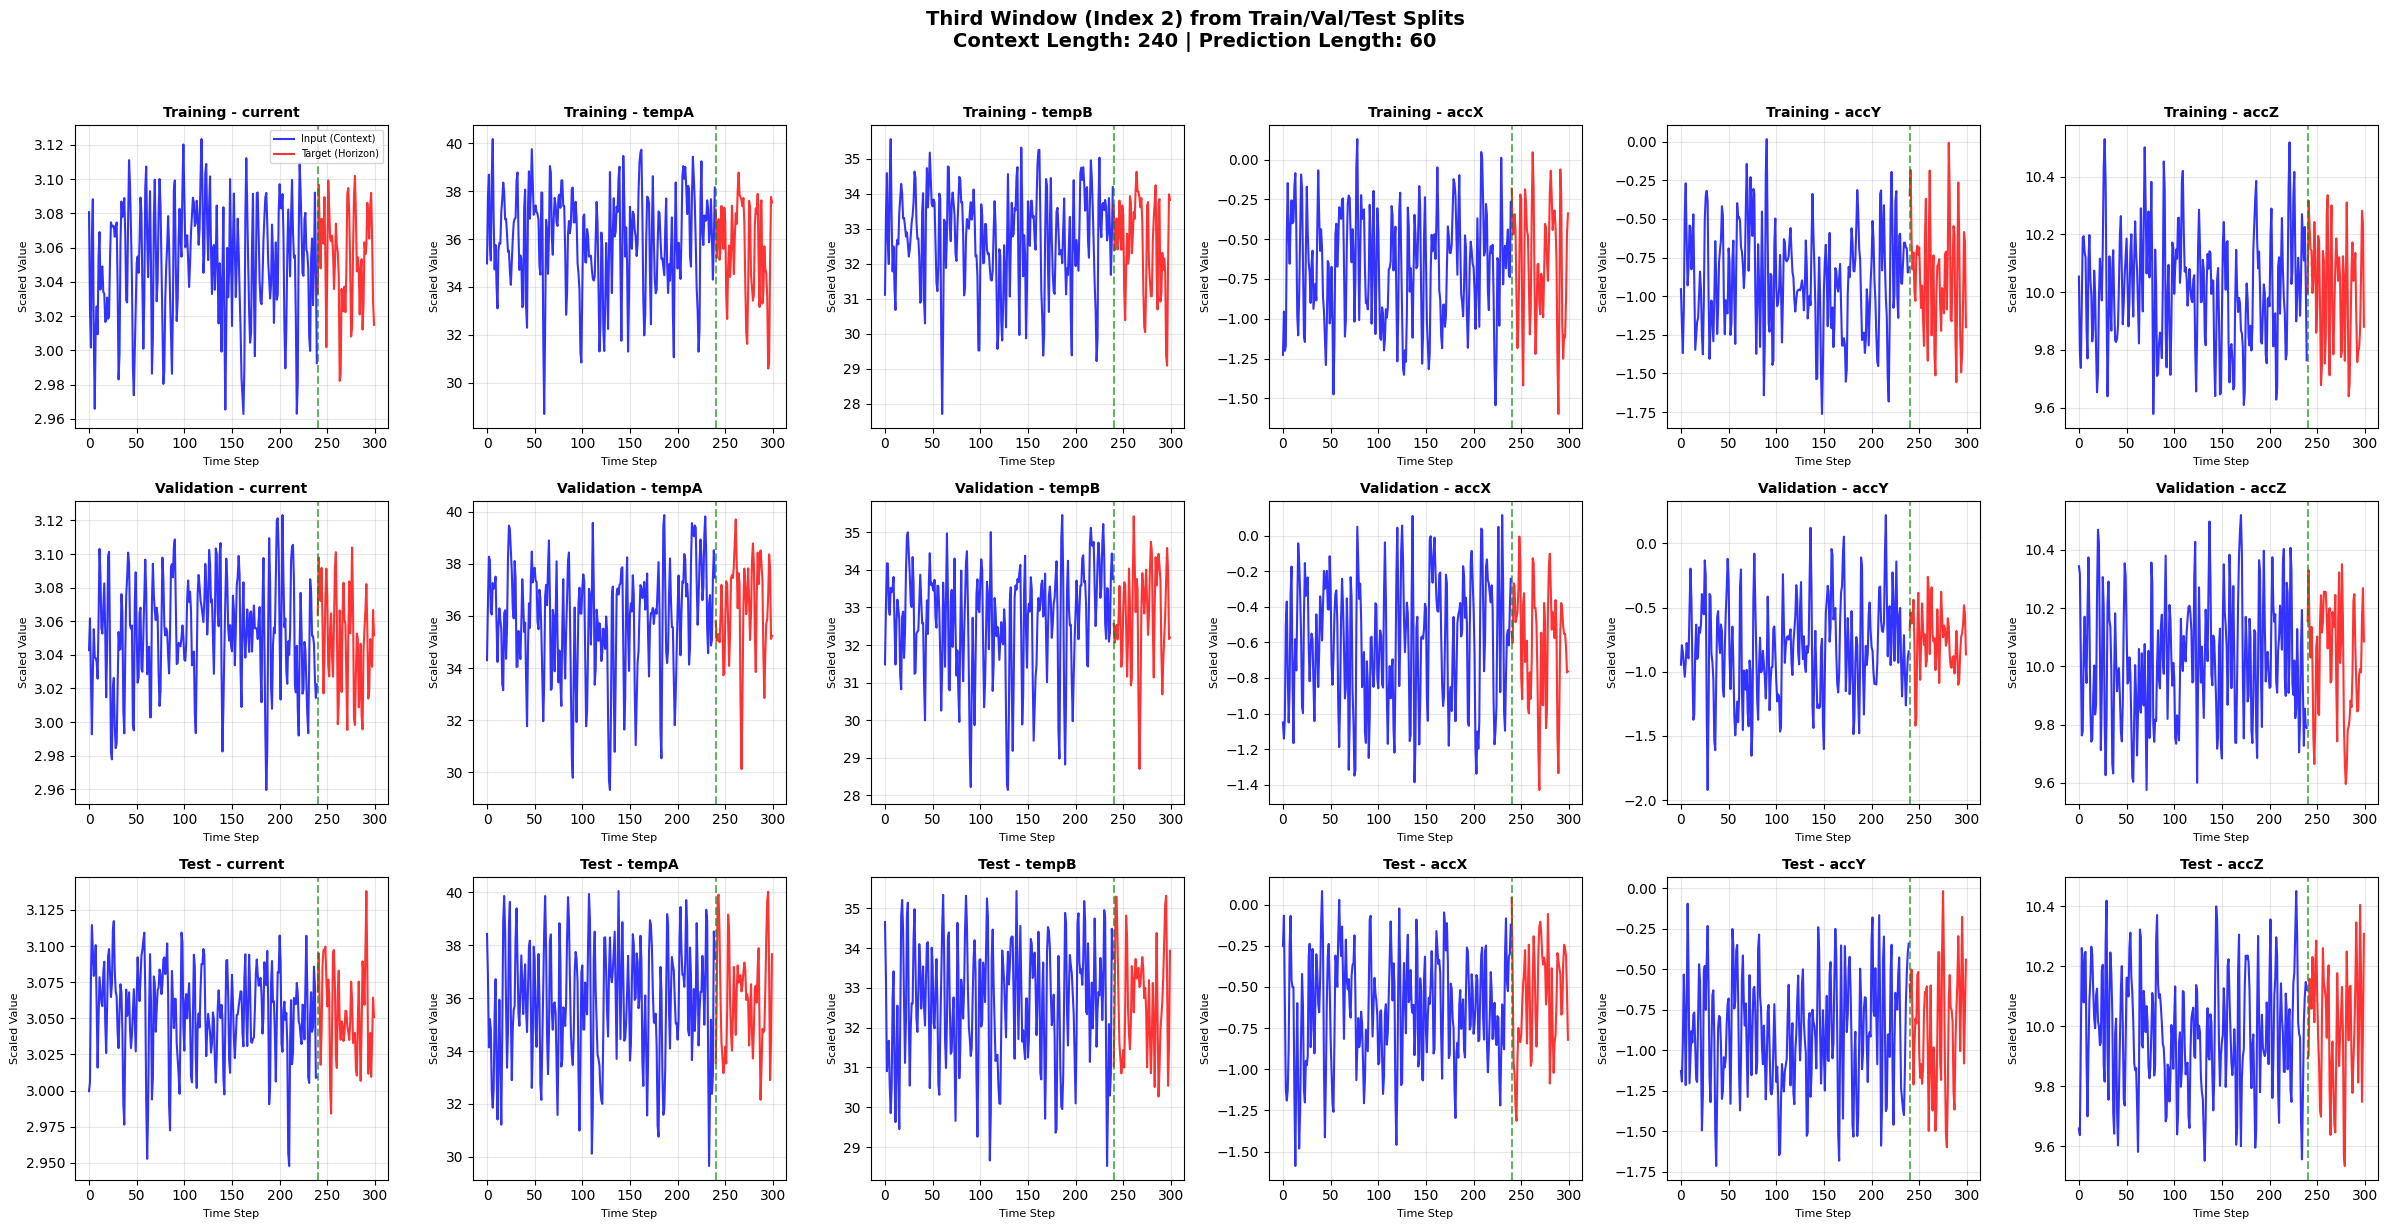


📊 Third Window Details:

TRAINING Window 3:
  Input shape: (240, 6)
  Target shape: (60, 6)
  Input (first 5 timesteps):
    current      tempA      tempB      accX      accY       accZ
0  3.080722  34.982254  31.119013 -1.226339 -0.954272  10.053980
1  3.024362  37.786198  33.317627 -0.955246 -1.183350   9.793116
2  3.001657  38.683910  34.595585 -1.201390 -1.367960   9.737933
3  3.066274  35.743671  32.632111 -1.170487 -1.091770   9.957922
4  3.088271  35.104893  31.998400 -0.473488 -0.471716  10.189038
  Target (first 5 timesteps):
    current      tempA      tempB      accX      accY       accZ
0  3.033365  37.223824  33.665241 -0.182221 -0.347708   9.998046
1  3.096716  35.217098  32.396057 -0.471341 -0.183577  10.316659
2  3.071270  36.019718  32.825405 -0.467338 -0.645792  10.231264
3  3.047853  36.826340  33.301994 -0.343254 -0.826548  10.149079
4  3.076882  35.134552  32.411949 -0.443459 -0.717219  10.142897

VALIDATION Window 3:
  Input shape: (240, 6)
  Target shape: (60, 6

In [16]:
# ==============================================
# LOAD AND VISUALIZE SAVED WINDOWS FROM DRIVE
# ==============================================

# Mount Google Drive (if using Colab)
from google.colab import drive
drive.mount('/content/drive')

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ✅ STEP 1: Define path to saved windows
# windows_dir = os.path.join(model_paths, "smoothed_windows")
windows_dir = "/content/drive/MyDrive/FYP/FYP-WF-8/Rextro/Models/PatchTSTs/SET-2/V4/cusloss/smoothed_windows"

print("="*80)
print("LOADING SAVED WINDOWS FROM DRIVE")
print("="*80)
print(f"\n📁 Loading from: {windows_dir}")

# ✅ STEP 2: Load metadata
metadata_path = os.path.join(windows_dir, "metadata.json")
with open(metadata_path, "r") as f:
    metadata = json.load(f)

context_length = metadata['context_length']
prediction_length = metadata['prediction_length']
num_features = metadata['num_features']
feature_cols = metadata['feature_cols']

print(f"\n📊 Metadata loaded:")
print(f"   Context Length: {context_length}")
print(f"   Prediction Length: {prediction_length}")
print(f"   Num Features: {num_features}")
print(f"   Feature Columns: {feature_cols}")

# ✅ STEP 3: Load all window arrays
print(f"\n📦 Loading window arrays...")

X_train_np = np.load(os.path.join(windows_dir, "X_train.npy"))
y_train_np = np.load(os.path.join(windows_dir, "y_train.npy"))
print(f"   ✅ Training: X_train {X_train_np.shape}, y_train {y_train_np.shape}")

X_val_np = np.load(os.path.join(windows_dir, "X_val.npy"))
y_val_np = np.load(os.path.join(windows_dir, "y_val.npy"))
print(f"   ✅ Validation: X_val {X_val_np.shape}, y_val {y_val_np.shape}")

X_test_np = np.load(os.path.join(windows_dir, "X_test.npy"))
y_test_np = np.load(os.path.join(windows_dir, "y_test.npy"))
print(f"   ✅ Test: X_test {X_test_np.shape}, y_test {y_test_np.shape}")

print("\n✅ All windows loaded successfully!")
print("="*80)

# ✅ STEP 4: VISUALIZE THIRD WINDOW FROM TRAIN/VAL/TEST SPLITS
print("\n" + "="*80)
print("VISUALIZING THIRD WINDOW FROM EACH SPLIT")
print("="*80)

window_idx = 2  # Third window (0-indexed)

fig, axes = plt.subplots(3, 6, figsize=(24, 12))

splits = [
    ("Training", X_train_np, y_train_np),
    ("Validation", X_val_np, y_val_np),
    ("Test", X_test_np, y_test_np)
]

for row_idx, (split_name, X_data, y_data) in enumerate(splits):
    for col_idx, col in enumerate(feature_cols):
        ax = axes[row_idx, col_idx]

        # Get input and target windows
        input_window = X_data[window_idx, :, col_idx]
        target_window = y_data[window_idx, :, col_idx]

        # Plot input (context) window
        ax.plot(range(context_length), input_window,
                label='Input (Context)', linewidth=1.5, color='blue', alpha=0.8)

        # Plot target (prediction) window
        ax.plot(range(context_length, context_length + prediction_length), target_window,
                label='Target (Horizon)', linewidth=1.5, color='red', alpha=0.8)

        # Add vertical line at forecast start
        ax.axvline(x=context_length, color='green', linestyle='--', alpha=0.6)

        ax.set_title(f'{split_name} - {col}', fontsize=10, fontweight='bold')
        ax.set_xlabel('Time Step', fontsize=8)
        ax.set_ylabel('Scaled Value', fontsize=8)
        ax.grid(True, alpha=0.3)

        if row_idx == 0 and col_idx == 0:
            ax.legend(fontsize=7, loc='best')

plt.suptitle(f'Third Window (Index {window_idx}) from Train/Val/Test Splits\n'
             f'Context Length: {context_length} | Prediction Length: {prediction_length}',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# ✅ STEP 5: Print numerical details for the third windows
print(f"\n📊 Third Window Details:")
print(f"\n{'='*40}")
print(f"TRAINING Window {window_idx + 1}:")
print(f"  Input shape: {X_train_np[window_idx].shape}")
print(f"  Target shape: {y_train_np[window_idx].shape}")
print(f"  Input (first 5 timesteps):\n{pd.DataFrame(X_train_np[window_idx][:5], columns=feature_cols)}")
print(f"  Target (first 5 timesteps):\n{pd.DataFrame(y_train_np[window_idx][:5], columns=feature_cols)}")

print(f"\n{'='*40}")
print(f"VALIDATION Window {window_idx + 1}:")
print(f"  Input shape: {X_val_np[window_idx].shape}")
print(f"  Target shape: {y_val_np[window_idx].shape}")
print(f"  Input (first 5 timesteps):\n{pd.DataFrame(X_val_np[window_idx][:5], columns=feature_cols)}")
print(f"  Target (first 5 timesteps):\n{pd.DataFrame(y_val_np[window_idx][:5], columns=feature_cols)}")

print(f"\n{'='*40}")
print(f"TEST Window {window_idx + 1}:")
print(f"  Input shape: {X_test_np[window_idx].shape}")
print(f"  Target shape: {y_test_np[window_idx].shape}")
print(f"  Input (first 5 timesteps):\n{pd.DataFrame(X_test_np[window_idx][:5], columns=feature_cols)}")
print(f"  Target (first 5 timesteps):\n{pd.DataFrame(y_test_np[window_idx][:5], columns=feature_cols)}")

print("\n✅ Third window visualization complete!")

In [17]:
class PatchWindowDataset(Dataset):
    def __init__(self, X_np, Y_np):
        self.X = torch.from_numpy(X_np)  # (N, L, C)
        self.Y = torch.from_numpy(Y_np)  # (N, T, C)
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return {
            "past_values": self.X[idx],
            "future_values": self.Y[idx]
        }

train_ds = PatchWindowDataset(X_train_np, y_train_np)
val_ds   = PatchWindowDataset(X_val_np,   y_val_np)
test_ds  = PatchWindowDataset(X_test_np,  y_test_np)


In [18]:
from transformers import Trainer
import torch.nn as nn
import torch


class CustomTrainer(Trainer):
    """Custom trainer with variance-preserving loss."""

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # ✅ FIX 1: Added num_items_in_batch parameter

        outputs = model(**inputs)
        predictions = outputs.prediction_outputs

        # Get targets - handle both tensor and tuple cases
        targets = inputs["future_values"]

        # ✅ FIX 2: If targets is a tuple, extract the first element
        if isinstance(targets, tuple):
            targets = targets[0]

        # Compute custom loss
        loss = custom_loss_fn(predictions, targets)

        return (loss, outputs) if return_outputs else loss


class HuberLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # 1. Forward pass
        # We don't rely on the model's internal loss calculation
        outputs = model(**inputs)

        # 2. Extract predictions and targets
        predictions = outputs.prediction_outputs
        targets = inputs["future_values"]

        # 3. Define Huber Loss (SmoothL1Loss)
        # beta=1.0 is the threshold where it switches from MSE to MAE behavior.
        # You can lower beta (e.g., 0.5) to make it less sensitive to outliers.
        loss_fct = nn.SmoothL1Loss(beta=1.0)

        loss = loss_fct(predictions, targets)

        return (loss, outputs) if return_outputs else loss


def mse_plus_lookback_mean(preds, targets, past_values):
    mse = torch.mean((preds - targets) ** 2)
    mean_lookback = torch.mean(past_values)
    return mse + mean_lookback

def mape_loss(preds, targets, eps=1e-6):
    return torch.mean(torch.abs((preds - targets) / (targets.abs() + eps)))


class CustomLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # Forward pass
        outputs = model(**inputs)

        # Extract predictions and targets
        preds = outputs.prediction_outputs
        targets = inputs["future_values"]
        past_values = inputs["past_values"]

        # Call your custom loss function
        loss = mse_plus_lookback_mean(preds, targets, past_values)

        return (loss, outputs) if return_outputs else loss


class MAPELossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # Forward pass
        outputs = model(**inputs)

        # Extract predictions and targets
        preds = outputs.prediction_outputs
        targets = inputs["future_values"]

        # Apply MAPE loss
        loss = mape_loss(preds, targets)

        return (loss, outputs) if return_outputs else loss


In [19]:
config = PatchTSTConfig(
    context_length=context_length,
    prediction_length=prediction_length,
    patch_length=20,
    patch_stride=10,
    num_input_channels=num_features, # 6
    num_targets=num_features,
    d_model=256,
    num_attention_heads=4,
    num_hidden_layers=3,
    ffn_dim=512,
    dropout=0.1,
    head_dropout=0.1,
    pooling_type=None,
    channel_attention=False,
    scaling='std',                  # Use when no scaling is used externally
    # scaling=None,                   # Use when scaling is used externally
    # loss="mse",
    loss='mse',
    activation_function="gelu",
    pre_norm=True,
    norm_type="batchnorm"
)

model = PatchTSTForPrediction(config).to(device)




# 🔍 DEBUG: Test model forward pass
print("\n" + "="*80)
print("🔍 PRE-TRAINING DEBUG CHECK")
print("="*80)

# Get a sample batch
sample_batch = next(iter(torch.utils.data.DataLoader(train_ds, batch_size=2)))
sample_past = sample_batch["past_values"].to(device)
sample_future = sample_batch["future_values"].to(device)

print(f"\nInput shape: {sample_past.shape}")
print(f"Target shape: {sample_future.shape}")

# Test model forward pass
with torch.no_grad():
    outputs = model(past_values=sample_past)
    preds = outputs.prediction_outputs

    if isinstance(preds, tuple):
        preds = preds[0]

    print(f"\nOutput shape: {preds.shape}")
    print(f"Output dtype: {preds.dtype}")
    print(f"Output device: {preds.device}")

    # Check if outputs are reasonable
    print(f"\nOutput statistics:")
    print(f"  Mean: {preds.mean():.6f}")
    print(f"  Std: {preds.std():.6f}")
    print(f"  Min: {preds.min():.6f}")
    print(f"  Max: {preds.max():.6f}")

    # Test loss calculation
    mae_loss = torch.nn.functional.l1_loss(preds, sample_future)
    mse_loss = torch.nn.functional.mse_loss(preds, sample_future)

    print(f"\nManual loss calculation:")
    print(f"  MAE Loss: {mae_loss.item():.6f}")
    print(f"  MSE Loss: {mse_loss.item():.6f}")

    if mae_loss < 0 or mse_loss < 0:
        print("🚨 ERROR: Loss is negative! This should never happen!")
    else:
        print("✅ Loss calculation looks OK")

print("="*80)




from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=os.path.join(model_paths, "checkpoints/patchtst_sensor"),
    overwrite_output_dir=True,
    learning_rate=1e-2,
    warmup_steps=100,
    lr_scheduler_type="cosine",
    num_train_epochs=20,
    do_eval=True,
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    dataloader_num_workers=2,
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    label_names=["future_values"],
    report_to="none",
    weight_decay=0.001,
    max_grad_norm=0.5,
)


from transformers import TrainerCallback

class AdjustLROnEpochCallback(TrainerCallback):
    def __init__(self, epoch_to_change=1, new_lr=5e-2):
        self.epoch_to_change = epoch_to_change
        self.new_lr = new_lr

    def on_epoch_begin(self, args, state, control, **kwargs):
        """Triggered at the start of each epoch"""
        if int(state.epoch) == self.epoch_to_change:
            print(f"\n🔽 Adjusting learning rate at epoch {state.epoch} to {self.new_lr}\n")
            for param_group in kwargs['optimizer'].param_groups:
                param_group['lr'] = self.new_lr
        return control



early_stop = EarlyStoppingCallback(
    early_stopping_patience=13,
    early_stopping_threshold=1e-4
)

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_ds,
#     eval_dataset=val_ds,
#     callbacks=[early_stop],
#     # callbacks=[early_stop, AdjustLROnEpochCallback(epoch_to_change=5, new_lr=3e-5)],
# )
# # Use CustomTrainer instead of Trainer
# trainer = CustomTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_ds,
#     eval_dataset=val_ds,
#     callbacks=[early_stop],
# )
# # Use HuberLossTrainer instead of Trainer
# trainer = HuberLossTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_ds,
#     eval_dataset=val_ds,
#     callbacks=[early_stop],
# )
# # Use CustomLossTrainer instead of Trainer
# trainer = CustomLossTrainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_ds,
#     eval_dataset=val_ds,
#     callbacks=[early_stop],
# )
# # Use MAPELossTrainer instead of Trainer
trainer = MAPELossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    callbacks=[early_stop],
)





🔍 PRE-TRAINING DEBUG CHECK

Input shape: torch.Size([2, 240, 6])
Target shape: torch.Size([2, 60, 6])

Output shape: torch.Size([2, 60, 6])
Output dtype: torch.float32
Output device: cuda:0

Output statistics:
  Mean: 13.405670
  Std: 15.373047
  Min: -1.191807
  Max: 37.649513

Manual loss calculation:
  MAE Loss: 0.593958
  MSE Loss: 1.102584
✅ Loss calculation looks OK


In [20]:
# NEW CELL: Verify Loss Function Works Correctly

print("\n" + "="*80)
print("🔍 LOSS FUNCTION VERIFICATION")
print("="*80)

# Get a test batch
sample_batch = next(iter(torch.utils.data.DataLoader(train_ds, batch_size=4)))
sample_past = sample_batch["past_values"].to(device)
sample_future = sample_batch["future_values"].to(device)

# Test forward pass + loss
model.train()
with torch.no_grad():
    outputs = model(
        past_values=sample_past,
        future_values=sample_future  # Include targets
    )

    # Extract predictions and loss
    preds = outputs.prediction_outputs
    if isinstance(preds, tuple):
        preds = preds[0]

    # Manual loss calculation
    manual_mse = torch.nn.functional.mse_loss(preds, sample_future)
    manual_mae = torch.nn.functional.l1_loss(preds, sample_future)

    # Model's internal loss (if available)
    model_loss = outputs.loss if hasattr(outputs, 'loss') else None

print(f"\n📊 Loss Values:")
print(f"  Manual MSE Loss:  {manual_mse.item():.6f}")
print(f"  Manual MAE Loss:  {manual_mae.item():.6f}")
if model_loss is not None:
    print(f"  Model's Internal Loss: {model_loss.item():.6f}")
    if model_loss.item() < 0:
        print("  🚨 ERROR: Loss is still negative!")
    else:
        print("  ✅ Loss is positive (good!)")
else:
    print("  ℹ️ Model doesn't compute internal loss")

print(f"\n📈 Prediction Statistics:")
print(f"  Pred Mean:  {preds.mean():.6f}")
print(f"  Pred Std:   {preds.std():.6f}")
print(f"  Target Mean: {sample_future.mean():.6f}")
print(f"  Target Std:  {sample_future.std():.6f}")

# Check if predictions are reasonable
if preds.std() > 100 * sample_future.std():
    print("\n🚨 WARNING: Predictions have extremely high variance!")
    print("   Model might still be outputting noise.")
else:
    print("\n✅ Prediction variance looks reasonable")

print("="*80)


🔍 LOSS FUNCTION VERIFICATION

📊 Loss Values:
  Manual MSE Loss:  1.163305
  Manual MAE Loss:  0.611748
  Model's Internal Loss: 1.163305
  ✅ Loss is positive (good!)

📈 Prediction Statistics:
  Pred Mean:  13.407810
  Pred Std:   15.362238
  Target Mean: 13.283844
  Target Std:  15.202852

✅ Prediction variance looks reasonable


In [21]:
print("\n" + "="*60)
print("🔍 WINDOW SANITY CHECK (Should be ~0 mean, ~1 std)")
print("="*60)

# Check training windows
print("\nX_train global statistics:")
print(f"   Mean: {X_train_np.mean():.6f} (should be ~0)")
print(f"   Std:  {X_train_np.std():.6f} (should be ~1)")
print(f"   Min:  {X_train_np.min():.6f}")
print(f"   Max:  {X_train_np.max():.6f}")

print("\ny_train global statistics:")
print(f"   Mean: {y_train_np.mean():.6f} (should be ~0)")
print(f"   Std:  {y_train_np.std():.6f} (should be ~1)")
print(f"   Min:  {y_train_np.min():.6f}")
print(f"   Max:  {y_train_np.max():.6f}")

# If these are NOT around 0/1, the scaling was applied incorrectly
if abs(X_train_np.mean()) > 0.5 or abs(X_train_np.std() - 1.0) > 0.3:
    print("\n🚨 WARNING: Training data may not be properly normalized!")
else:
    print("\n✅ Training data appears properly normalized")


🔍 WINDOW SANITY CHECK (Should be ~0 mean, ~1 std)

X_train global statistics:
   Mean: 13.328317 (should be ~0)
   Std:  15.259542 (should be ~1)
   Min:  -1.893028
   Max:  40.827671

y_train global statistics:
   Mean: 13.328196 (should be ~0)
   Std:  15.259359 (should be ~1)
   Min:  -1.893028
   Max:  40.827671

🚨 WARNING: Training data may not be properly normalized!


In [22]:
torch.cuda.empty_cache()
trainer.train()


TrainOutput(global_step=65260, training_loss=14.764470638704198, metrics={'train_runtime': 1260.642, 'train_samples_per_second': 828.165, 'train_steps_per_second': 51.767, 'total_flos': 1.75528099208448e+16, 'train_loss': 14.764470638704198, 'epoch': 20.0})

In [23]:
print("\n🔍 Model parameter statistics:")
for name, param in model.named_parameters():
    print(f"{name}: mean={param.mean():.4f}, std={param.std():.4f}, max={param.max():.4f}")


🔍 Model parameter statistics:
model.encoder.embedder.input_embedding.weight: mean=0.0000, std=0.0620, max=0.5051
model.encoder.embedder.input_embedding.bias: mean=-0.0021, std=0.0117, max=0.0194
model.encoder.positional_encoder.position_enc: mean=0.0000, std=0.1000, max=0.1013
model.encoder.layers.0.self_attn.k_proj.weight: mean=0.0002, std=0.5108, max=2.7025
model.encoder.layers.0.self_attn.k_proj.bias: mean=-0.0001, std=0.0020, max=0.0057
model.encoder.layers.0.self_attn.v_proj.weight: mean=-0.0000, std=0.0182, max=0.1039
model.encoder.layers.0.self_attn.v_proj.bias: mean=0.0000, std=0.0009, max=0.0024
model.encoder.layers.0.self_attn.q_proj.weight: mean=-0.0028, std=0.5702, max=2.4799
model.encoder.layers.0.self_attn.q_proj.bias: mean=0.0006, std=0.0249, max=0.0712
model.encoder.layers.0.self_attn.out_proj.weight: mean=-0.0001, std=0.0233, max=0.1175
model.encoder.layers.0.self_attn.out_proj.bias: mean=-0.0021, std=0.0117, max=0.0194
model.encoder.layers.0.norm_sublayer1.batchnorm.

In [24]:
# NEW CELL: Monitor variance metrics

def evaluate_variance_metrics(model, test_ds, device):
    """Evaluate how well model preserves variance."""
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in torch.utils.data.DataLoader(test_ds, batch_size=32):
            past = batch["past_values"].to(device)
            future = batch["future_values"].to(device)

            outputs = model(past_values=past)
            preds = outputs.prediction_outputs

            # ✅ FIX: Handle tuple output from model
            if isinstance(preds, tuple):
                preds = preds[0]  # Extract first element (predictions tensor)

            all_preds.append(preds.cpu().numpy())
            all_targets.append(future.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)      # (N, horizon, features)
    all_targets = np.concatenate(all_targets, axis=0)

    print("\n" + "="*80)
    print("VARIANCE PRESERVATION METRICS")
    print("="*80)

    for feat_idx in range(num_features):
        pred_var = np.var(all_preds[:, :, feat_idx])
        target_var = np.var(all_targets[:, :, feat_idx])
        ratio = pred_var / target_var if target_var > 0 else 0

        # # ✅ ADDED: Check if ratio is reasonable
        # ratio_status = "✅ GOOD" if 0.7 <= ratio <= 1.3 else "❌ BAD"
        # # ✅ ADDED: Warn if variance is too high/low
        # if ratio > 10:
        #     ratio_status = "🚨 TOO HIGH (Model outputting noise!)"
        # elif ratio < 0.1:
        #     ratio_status = "🚨 TOO LOW (Flat predictions!)"

        print(f"\nFeature {feat_idx} ({feature_cols[feat_idx]}):")
        print(f"  Target Variance:     {target_var:.6f}")
        print(f"  Predicted Variance:  {pred_var:.6f}")
        print(f"  Variance Ratio:      {ratio:.4f}")
        # print(f"  Variance Ratio:      {ratio:.4f} {ratio_status}")

# Run evaluation
evaluate_variance_metrics(model, test_ds, device)


VARIANCE PRESERVATION METRICS

Feature 0 (current):
  Target Variance:     0.001075
  Predicted Variance:  0.000039
  Variance Ratio:      0.0366

Feature 1 (tempA):
  Target Variance:     4.378254
  Predicted Variance:  0.161184
  Variance Ratio:      0.0368

Feature 2 (tempB):
  Target Variance:     2.030632
  Predicted Variance:  0.077455
  Variance Ratio:      0.0381

Feature 3 (accX):
  Target Variance:     0.104010
  Predicted Variance:  0.004043
  Variance Ratio:      0.0389

Feature 4 (accY):
  Target Variance:     0.117272
  Predicted Variance:  0.004418
  Variance Ratio:      0.0377

Feature 5 (accZ):
  Target Variance:     0.040621
  Predicted Variance:  0.001559
  Variance Ratio:      0.0384



STEP 4.5: TRAINING HISTORY ANALYSIS

Training completed: 652 training steps, 20 evaluation steps

Training Losses (First 20 steps):
  Step 1: Epoch 0.030646644192460926, Loss: 16.7663
  Step 2: Epoch 0.06129328838492185, Loss: 24.2278
  Step 3: Epoch 0.09193993257738278, Loss: 15.4205
  Step 4: Epoch 0.1225865767698437, Loss: 15.1421
  Step 5: Epoch 0.15323322096230463, Loss: 15.1911
  Step 6: Epoch 0.18387986515476556, Loss: 15.1565
  Step 7: Epoch 0.21452650934722647, Loss: 15.1771
  Step 8: Epoch 0.2451731535396874, Loss: 15.1693
  Step 9: Epoch 0.2758197977321483, Loss: 15.1394
  Step 10: Epoch 0.30646644192460926, Loss: 15.1259
  Step 11: Epoch 0.3371130861170702, Loss: 15.1164
  Step 12: Epoch 0.36775973030953113, Loss: 15.1352
  Step 13: Epoch 0.398406374501992, Loss: 15.116
  Step 14: Epoch 0.42905301869445295, Loss: 15.104
  Step 15: Epoch 0.4596996628869139, Loss: 15.1376
  Step 16: Epoch 0.4903463070793748, Loss: 15.0876
  Step 17: Epoch 0.5209929512718358, Loss: 15.1015
  

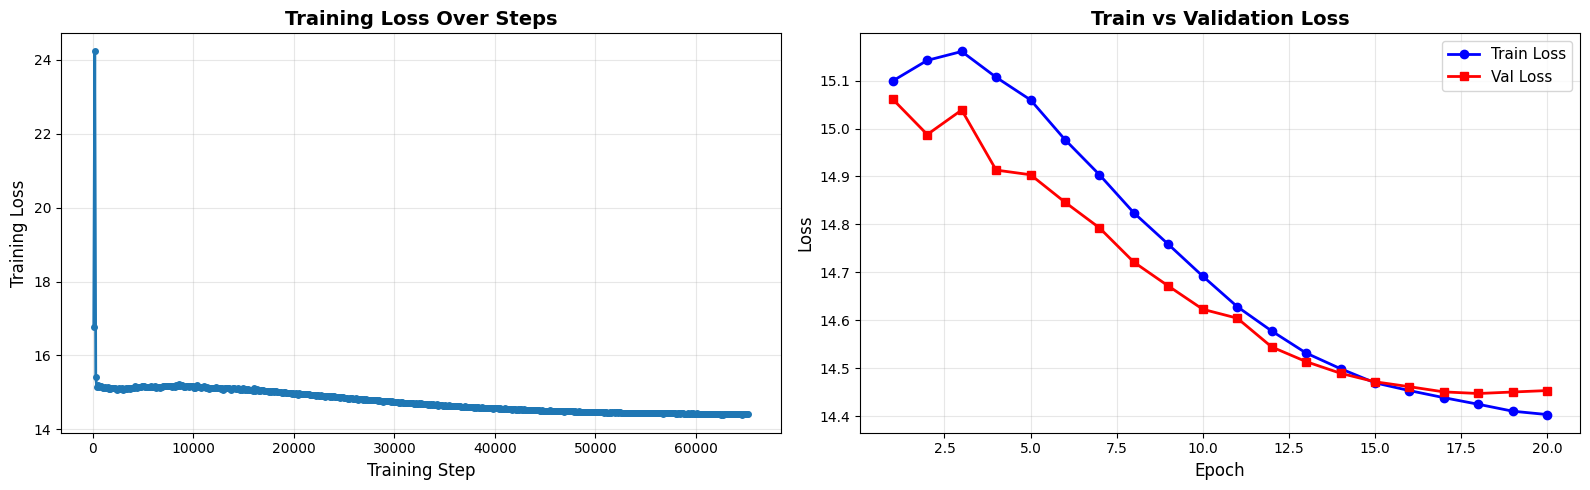


📊 Final Training Metrics:
  Final Train Loss: 14.403400
  Final Val Loss: 14.453489
  Train-Val Gap: 0.050089
  ✅ Train-val gap looks reasonable

✅ Training history analysis complete!


In [25]:
# ✅ STEP 4.5: Visualize Training History
print("\n" + "="*80)
print("STEP 4.5: TRAINING HISTORY ANALYSIS")
print("="*80)

# Extract training logs
train_history = trainer.state.log_history

# Separate train and eval logs
train_logs = [log for log in train_history if 'loss' in log and 'eval_loss' not in log]
eval_logs = [log for log in train_history if 'eval_loss' in log]

print(f"\nTraining completed: {len(train_logs)} training steps, {len(eval_logs)} evaluation steps")

# Print training logs
if train_logs:
    print(f"\nTraining Losses (First {min(20, len(train_logs))} steps):")
    for i, log in enumerate(train_logs[:20]):
        epoch = log.get('epoch', 'N/A')
        loss = log.get('loss', 'N/A')
        print(f"  Step {i+1}: Epoch {epoch}, Loss: {loss}")

# Print eval logs
if eval_logs:
    print(f"\nValidation Losses:")
    for i, log in enumerate(eval_logs):
        epoch = log.get('epoch', 'N/A')
        eval_loss = log.get('eval_loss', 'N/A')
        print(f"  Evaluation {i+1}: Epoch {epoch}, Eval Loss: {eval_loss}")

# Plot training curves
if train_logs and eval_logs:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

    # Plot 1: Training loss over steps
    train_steps = [log.get('step', i) for i, log in enumerate(train_logs)]
    train_losses = [log.get('loss', 0) for log in train_logs]

    ax1.plot(train_steps, train_losses, marker='o', linewidth=2, markersize=4)
    ax1.set_xlabel('Training Step', fontsize=12)
    ax1.set_ylabel('Training Loss', fontsize=12)
    ax1.set_title('Training Loss Over Steps', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)

    # Plot 2: Train vs Validation loss
    eval_epochs = [log.get('epoch', i) for i, log in enumerate(eval_logs)]
    eval_losses = [log.get('eval_loss', 0) for log in eval_logs]

    # Match train losses to eval epochs
    train_epoch_losses = []
    for epoch in eval_epochs:
        matching_logs = [log['loss'] for log in train_logs if abs(log.get('epoch', 0) - epoch) < 0.1]
        if matching_logs:
            train_epoch_losses.append(np.mean(matching_logs))
        else:
            train_epoch_losses.append(None)

    ax2.plot(eval_epochs, train_epoch_losses, marker='o', linewidth=2,
             markersize=6, label='Train Loss', color='blue')
    ax2.plot(eval_epochs, eval_losses, marker='s', linewidth=2,
             markersize=6, label='Val Loss', color='red')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_title('Train vs Validation Loss', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Check for overfitting
    if len(eval_losses) > 1:
        final_train = train_epoch_losses[-1] if train_epoch_losses[-1] is not None else 0
        final_val = eval_losses[-1]
        gap = final_val - final_train

        print(f"\n📊 Final Training Metrics:")
        print(f"  Final Train Loss: {final_train:.6f}")
        print(f"  Final Val Loss: {final_val:.6f}")
        print(f"  Train-Val Gap: {gap:.6f}")

        if gap > 0.1:
            print("  ⚠️ WARNING: Large train-val gap suggests overfitting!")
        elif gap < -0.05:
            print("  ⚠️ WARNING: Val loss lower than train loss (unusual)")
        else:
            print("  ✅ Train-val gap looks reasonable")
else:
    print("⚠️ Training history not available")

print("\n✅ Training history analysis complete!")

In [26]:
# # Evaluate
# test_metrics = trainer.evaluate(test_ds)
# print("Test metrics:", test_metrics)

# # Forecast on the test window
# last_past = torch.from_numpy(X_test_np[-100:-99]).to(device)  # (1, L, C)
# # last_past = torch.from_numpy(X_test_np[-1:]).to(device)  # (1, L, C)
# with torch.no_grad():
#     out = model(past_values=last_past)

# # ✅ FIX: Handle tuple output
# preds = out.prediction_outputs
# if isinstance(preds, tuple):
#     preds = preds[0]  # Extract predictions tensor from tuple

# pred = preds.squeeze(0).cpu().numpy()          # (T, C)
# gt   = y_test_np[-100]                         # (T, C)
# # gt   = y_test_np[-1]

# # ✅ STEP 5: Print prediction results (First 500 timesteps or all if less)
# print("\n" + "="*80)
# print("STEP 5: MODEL PREDICTIONS")
# print("="*80)
# print(f"\nPrediction shape: {pred.shape}")
# print(f"Ground truth shape: {gt.shape}")

# # Print predictions and ground truth
# timesteps_to_show = min(500, prediction_length)
# print(f"\nPredictions (First {timesteps_to_show} timesteps):")
# df_pred = pd.DataFrame(pred[:timesteps_to_show], columns=feature_cols)
# df_pred.index.name = 'Timestep'
# # print(df_pred)

# print(f"\nGround Truth (First {timesteps_to_show} timesteps):")
# df_gt = pd.DataFrame(gt[:timesteps_to_show], columns=feature_cols)
# df_gt.index.name = 'Timestep'
# # print(df_gt)

# # Calculate per-feature metrics
# print(f"\nPer-Feature Metrics (First {timesteps_to_show} timesteps):")
# metrics_list = []
# for i, col in enumerate(feature_cols):
#     mae = np.mean(np.abs(pred[:timesteps_to_show, i] - gt[:timesteps_to_show, i]))
#     rmse = np.sqrt(np.mean((pred[:timesteps_to_show, i] - gt[:timesteps_to_show, i])**2))
#     mape = np.mean(np.abs((gt[:timesteps_to_show, i] - pred[:timesteps_to_show, i]) /
#                           (np.abs(gt[:timesteps_to_show, i]) + 1e-8))) * 100

#     # Check if predictions are flat
#     pred_std = np.std(pred[:timesteps_to_show, i])
#     gt_std = np.std(gt[:timesteps_to_show, i])

#     metrics_list.append({
#         'Feature': col,
#         'MAE': f'{mae:.6f}',
#         'RMSE': f'{rmse:.6f}',
#         'MAPE': f'{mape:.2f}%',
#         'Pred_Std': f'{pred_std:.6f}',
#         'GT_Std': f'{gt_std:.6f}',
#         'Flatness_Ratio': f'{pred_std/gt_std:.4f}' if gt_std > 0 else 'N/A'
#     })

# metrics_df = pd.DataFrame(metrics_list)
# print(metrics_df.to_string(index=False))

# # Warning if predictions are too flat
# print("\n⚠️ FLATNESS CHECK:")
# for i, col in enumerate(feature_cols):
#     pred_range = pred[:, i].max() - pred[:, i].min()
#     gt_range = gt[:, i].max() - gt[:, i].min()
#     flatness_ratio = pred_range / gt_range if gt_range > 0 else 0

#     if flatness_ratio < 0.3:
#         print(f"🚨 WARNING: {col} predictions are TOO FLAT!")
#         print(f"   Prediction range: {pred_range:.6f}, Ground truth range: {gt_range:.6f}")
#         print(f"   Flatness ratio: {flatness_ratio:.4f} (should be > 0.5 for good predictions)")
#     else:
#         print(f"✅ {col}: Flatness ratio = {flatness_ratio:.4f} (OK)")

# # Plot first 100 forecast points vs ground truth per feature
# steps_to_plot = min(100, prediction_length)
# fig, axes = plt.subplots(4, 2, figsize=(16, 12), sharex=True)
# axes = axes.flatten()

# for i in range(num_features):
#     ax = axes[i]
#     ax.plot(gt[:steps_to_plot, i], label="Ground Truth", linewidth=2, marker='o', markersize=3)
#     ax.plot(pred[:steps_to_plot, i], label="Forecast", linewidth=2, linestyle="--", marker='s', markersize=3)

#     # Add shaded error region
#     ax.fill_between(range(steps_to_plot),
#                      pred[:steps_to_plot, i] - np.abs(pred[:steps_to_plot, i] - gt[:steps_to_plot, i]),
#                      pred[:steps_to_plot, i] + np.abs(pred[:steps_to_plot, i] - gt[:steps_to_plot, i]),
#                      alpha=0.2, color='red')

#     # Calculate metrics for this window
#     mae = np.mean(np.abs(pred[:steps_to_plot, i] - gt[:steps_to_plot, i]))

#     ax.set_title(f"Feature {i} ({feature_cols[i]}) - MAE: {mae:.4f}", fontweight='bold')
#     ax.set_ylabel("Scaled value")
#     ax.grid(True, alpha=0.3)
#     ax.legend()

# axes[-1].set_xlabel("Time steps (forecast horizon)")
# plt.suptitle(f'Model Predictions vs Ground Truth (First {steps_to_plot} steps)',
#              fontsize=16, fontweight='bold', y=1.00)
# plt.tight_layout()
# plt.show()

# # # ✅ ADDITIONAL VISUALIZATION: Residuals (Errors)
# # fig, axes = plt.subplots(4, 2, figsize=(16, 12))
# # axes = axes.flatten()

# # for i in range(num_features):
# #     ax = axes[i]
# #     residuals = pred[:steps_to_plot, i] - gt[:steps_to_plot, i]

# #     ax.plot(residuals, label="Residuals (Pred - GT)", linewidth=2, color='red', alpha=0.7)
# #     ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
# #     ax.axhline(y=np.mean(residuals), color='blue', linestyle='--', linewidth=1,
# #                label=f'Mean Error: {np.mean(residuals):.4f}')

# #     ax.set_title(f"{feature_cols[i]} - Prediction Errors", fontweight='bold')
# #     ax.set_xlabel("Time steps")
# #     ax.set_ylabel("Error (Pred - GT)")
# #     ax.grid(True, alpha=0.3)
# #     ax.legend()

# # plt.suptitle('Prediction Residuals Analysis', fontsize=16, fontweight='bold', y=1.00)
# # plt.tight_layout()
# # plt.show()

# print("\n✅ Model evaluation and visualization complete!")

In [27]:
# # ==============================================
# # LOAD TEST WINDOWS FROM DRIVE AND EVALUATE MODEL
# # ==============================================

# from google.colab import drive
# drive.mount('/content/drive')

# import os
# import json
# import numpy as np
# import pandas as pd
# import torch
# import matplotlib.pyplot as plt

# # ✅ STEP 1: Define paths
# windows_dir = "/content/drive/MyDrive/FYP/FYP-WF-8/Rextro/Models/PatchTSTs/SET-2/V3/smoothed_windows"
# model_dir = "/content/drive/MyDrive/FYP/FYP-WF-8/Rextro/Models/PatchTSTs/SET-2/V3/artifacts/patchtst_sensor_multivar/"

# print("="*80)
# print("LOADING TEST WINDOWS AND MODEL FROM DRIVE")
# print("="*80)

# # ✅ STEP 2: Load metadata
# print(f"\n📁 Loading metadata from: {windows_dir}")
# metadata_path = os.path.join(windows_dir, "metadata.json")
# with open(metadata_path, "r") as f:
#     metadata = json.load(f)

# context_length = metadata['context_length']
# prediction_length = metadata['prediction_length']
# num_features = metadata['num_features']
# feature_cols = metadata['feature_cols']

# print(f"   Context Length: {context_length}")
# print(f"   Prediction Length: {prediction_length}")
# print(f"   Num Features: {num_features}")
# print(f"   Feature Columns: {feature_cols}")

# # ✅ STEP 3: Load test windows
# print(f"\n📦 Loading test windows...")
# X_test_np = np.load(os.path.join(windows_dir, "X_test.npy"))
# y_test_np = np.load(os.path.join(windows_dir, "y_test.npy"))
# print(f"   ✅ X_test shape: {X_test_np.shape}")
# print(f"   ✅ y_test shape: {y_test_np.shape}")

# # ✅ STEP 4: Load model
# print(f"\n🤖 Loading model from: {model_dir}")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# from transformers import PatchTSTForPrediction
# model = PatchTSTForPrediction.from_pretrained(model_dir, local_files_only=True).to(device)
# model.eval()
# print(f"   ✅ Model loaded on device: {device}")

# print("\n" + "="*80)
# print("EVALUATING MODEL ON TEST DATA")
# print("="*80)

# # ✅ STEP 5: Select a test window and make prediction
# # Using window at index -100 (100th from the end)
# window_idx = -2
# print(f"\n📊 Evaluating on test window index: {window_idx}")

# # Get input and ground truth
# X_input = X_test_np[window_idx:window_idx+1]  # Shape: (1, context_length, num_features)
# y_ground_truth = y_test_np[window_idx]         # Shape: (prediction_length, num_features)

# print(f"   Input shape: {X_input.shape}")
# print(f"   Ground truth shape: {y_ground_truth.shape}")

# # Convert to tensor and make prediction
# last_past = torch.from_numpy(X_input).to(device)

# with torch.no_grad():
#     out = model(past_values=last_past)

# # Handle tuple output
# preds = out.prediction_outputs
# if isinstance(preds, tuple):
#     preds = preds[0]

# pred = preds.squeeze(0).cpu().numpy()  # Shape: (prediction_length, num_features)
# gt = y_ground_truth                     # Shape: (prediction_length, num_features)

# print(f"\n   Prediction shape: {pred.shape}")
# print(f"   Ground truth shape: {gt.shape}")

# # ✅ STEP 6: Print prediction results
# print("\n" + "="*80)
# print("MODEL PREDICTIONS")
# print("="*80)

# timesteps_to_show = min(500, prediction_length)
# print(f"\nPredictions (First {timesteps_to_show} timesteps):")
# df_pred = pd.DataFrame(pred[:timesteps_to_show], columns=feature_cols)
# df_pred.index.name = 'Timestep'
# print(df_pred)

# print(f"\nGround Truth (First {timesteps_to_show} timesteps):")
# df_gt = pd.DataFrame(gt[:timesteps_to_show], columns=feature_cols)
# df_gt.index.name = 'Timestep'
# print(df_gt)

# # ✅ STEP 7: Calculate per-feature metrics
# print(f"\n📈 Per-Feature Metrics:")
# metrics_list = []
# for i, col in enumerate(feature_cols):
#     mae = np.mean(np.abs(pred[:, i] - gt[:, i]))
#     rmse = np.sqrt(np.mean((pred[:, i] - gt[:, i])**2))
#     mape = np.mean(np.abs((gt[:, i] - pred[:, i]) / (np.abs(gt[:, i]) + 1e-8))) * 100

#     pred_std = np.std(pred[:, i])
#     gt_std = np.std(gt[:, i])
#     flatness_ratio = pred_std / gt_std if gt_std > 0 else 0

#     metrics_list.append({
#         'Feature': col,
#         'MAE': f'{mae:.6f}',
#         'RMSE': f'{rmse:.6f}',
#         'MAPE': f'{mape:.2f}%',
#         'Pred_Std': f'{pred_std:.6f}',
#         'GT_Std': f'{gt_std:.6f}',
#         'Flatness_Ratio': f'{flatness_ratio:.4f}'
#     })

# metrics_df = pd.DataFrame(metrics_list)
# print(metrics_df.to_string(index=False))

# # ✅ STEP 8: Flatness check
# print("\n⚠️ FLATNESS CHECK:")
# for i, col in enumerate(feature_cols):
#     pred_range = pred[:, i].max() - pred[:, i].min()
#     gt_range = gt[:, i].max() - gt[:, i].min()
#     flatness_ratio = pred_range / gt_range if gt_range > 0 else 0

#     if flatness_ratio < 0.3:
#         print(f"🚨 WARNING: {col} predictions are TOO FLAT!")
#         print(f"   Prediction range: {pred_range:.6f}, Ground truth range: {gt_range:.6f}")
#         print(f"   Flatness ratio: {flatness_ratio:.4f} (should be > 0.5)")
#     else:
#         print(f"✅ {col}: Flatness ratio = {flatness_ratio:.4f} (OK)")

# # ✅ STEP 9: Visualization - Predictions vs Ground Truth
# print("\n" + "="*80)
# print("VISUALIZATION")
# print("="*80)

# steps_to_plot = min(100, prediction_length)
# fig, axes = plt.subplots(3, 2, figsize=(16, 12), sharex=True)
# axes = axes.flatten()

# for i in range(num_features):
#     ax = axes[i]
#     ax.plot(gt[:steps_to_plot, i], label="Ground Truth", linewidth=2, marker='o', markersize=3)
#     ax.plot(pred[:steps_to_plot, i], label="Forecast", linewidth=2, linestyle="--", marker='s', markersize=3)

#     # Add shaded error region
#     ax.fill_between(range(steps_to_plot),
#                     pred[:steps_to_plot, i] - np.abs(pred[:steps_to_plot, i] - gt[:steps_to_plot, i]),
#                     pred[:steps_to_plot, i] + np.abs(pred[:steps_to_plot, i] - gt[:steps_to_plot, i]),
#                     alpha=0.2, color='red')

#     mae = np.mean(np.abs(pred[:steps_to_plot, i] - gt[:steps_to_plot, i]))
#     ax.set_title(f"{feature_cols[i]} - MAE: {mae:.4f}", fontweight='bold')
#     ax.set_ylabel("Scaled value")
#     ax.grid(True, alpha=0.3)
#     ax.legend()

# axes[-1].set_xlabel("Time steps (forecast horizon)")
# plt.suptitle(f'Model Predictions vs Ground Truth (Window {window_idx}, First {steps_to_plot} steps)',
#              fontsize=16, fontweight='bold', y=1.00)
# plt.tight_layout()
# plt.show()

# # ✅ STEP 10: Visualization - Input Context + Prediction
# fig, axes = plt.subplots(3, 2, figsize=(16, 12))
# axes = axes.flatten()

# for i in range(num_features):
#     ax = axes[i]

#     # Plot input context
#     input_context = X_input[0, :, i]
#     ax.plot(range(context_length), input_context,
#             label='Input Context', linewidth=1.5, color='blue', alpha=0.7)

#     # Plot ground truth (future)
#     ax.plot(range(context_length, context_length + prediction_length), gt[:, i],
#             label='Ground Truth', linewidth=2, color='green', marker='o', markersize=3)

#     # Plot prediction
#     ax.plot(range(context_length, context_length + prediction_length), pred[:, i],
#             label='Prediction', linewidth=2, color='red', linestyle='--', marker='s', markersize=3)

#     # Vertical line at forecast start
#     ax.axvline(x=context_length, color='gray', linestyle='--', alpha=0.5)

#     ax.set_title(f"{feature_cols[i]} - Context + Forecast", fontweight='bold')
#     ax.set_xlabel("Time Step")
#     ax.set_ylabel("Scaled Value")
#     ax.legend(loc='best', fontsize=8)
#     ax.grid(True, alpha=0.3)

# plt.suptitle(f'Full Window: Input Context ({context_length}) → Forecast ({prediction_length})',
#              fontsize=16, fontweight='bold', y=1.00)
# plt.tight_layout()
# plt.show()

# print("\n✅ Model evaluation and visualization complete!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
LOADING TEST WINDOWS FROM DRIVE
   Context Length (saved windows): 240
   Prediction Length: 60
   Num Features: 6
   Feature Columns: ['current', 'tempA', 'tempB', 'accX', 'accY', 'accZ']

⚠ Using the model already trained in this notebook (NOT loading from Drive).

📦 Loading test windows...
   X_test shape: (6701, 240, 6)
   y_test shape: (6701, 60, 6)

🔧 Model expects input length: 240
✅ Context length matches model.

EVALUATING MODEL ON TEST DATA

📊 Evaluating on test window index: -2
   Adjusted Input shape: (1, 240, 6)
   Ground truth shape: (60, 6)

   Prediction shape: (60, 6)
   Ground truth shape: (60, 6)

Predictions (In Model Scale):
    current      tempA      tempB      accX      accY       accZ
0  3.011786  36.045097  32.774895 -0.841752 -1.131267  10.046503
1  3.052072  35.256199  32.202847 -0.633551 -0.885359  10.118699
2  3.058809  36.113708

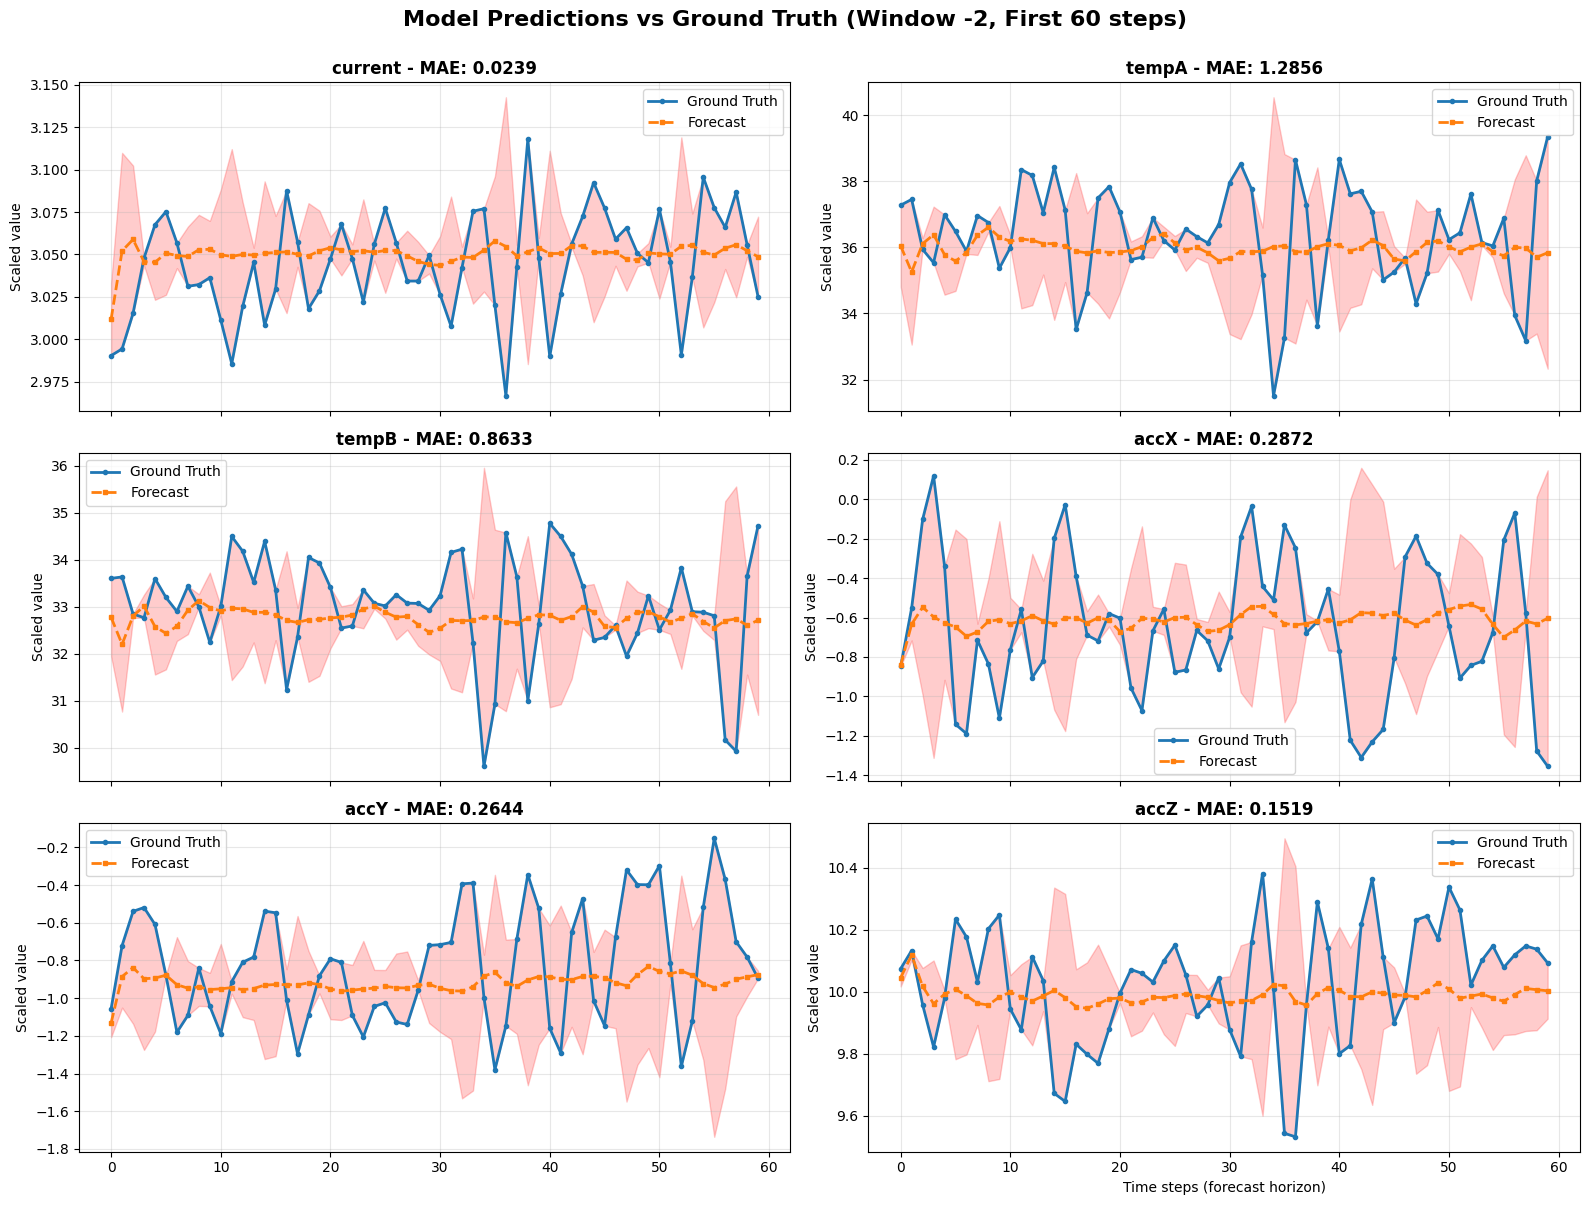

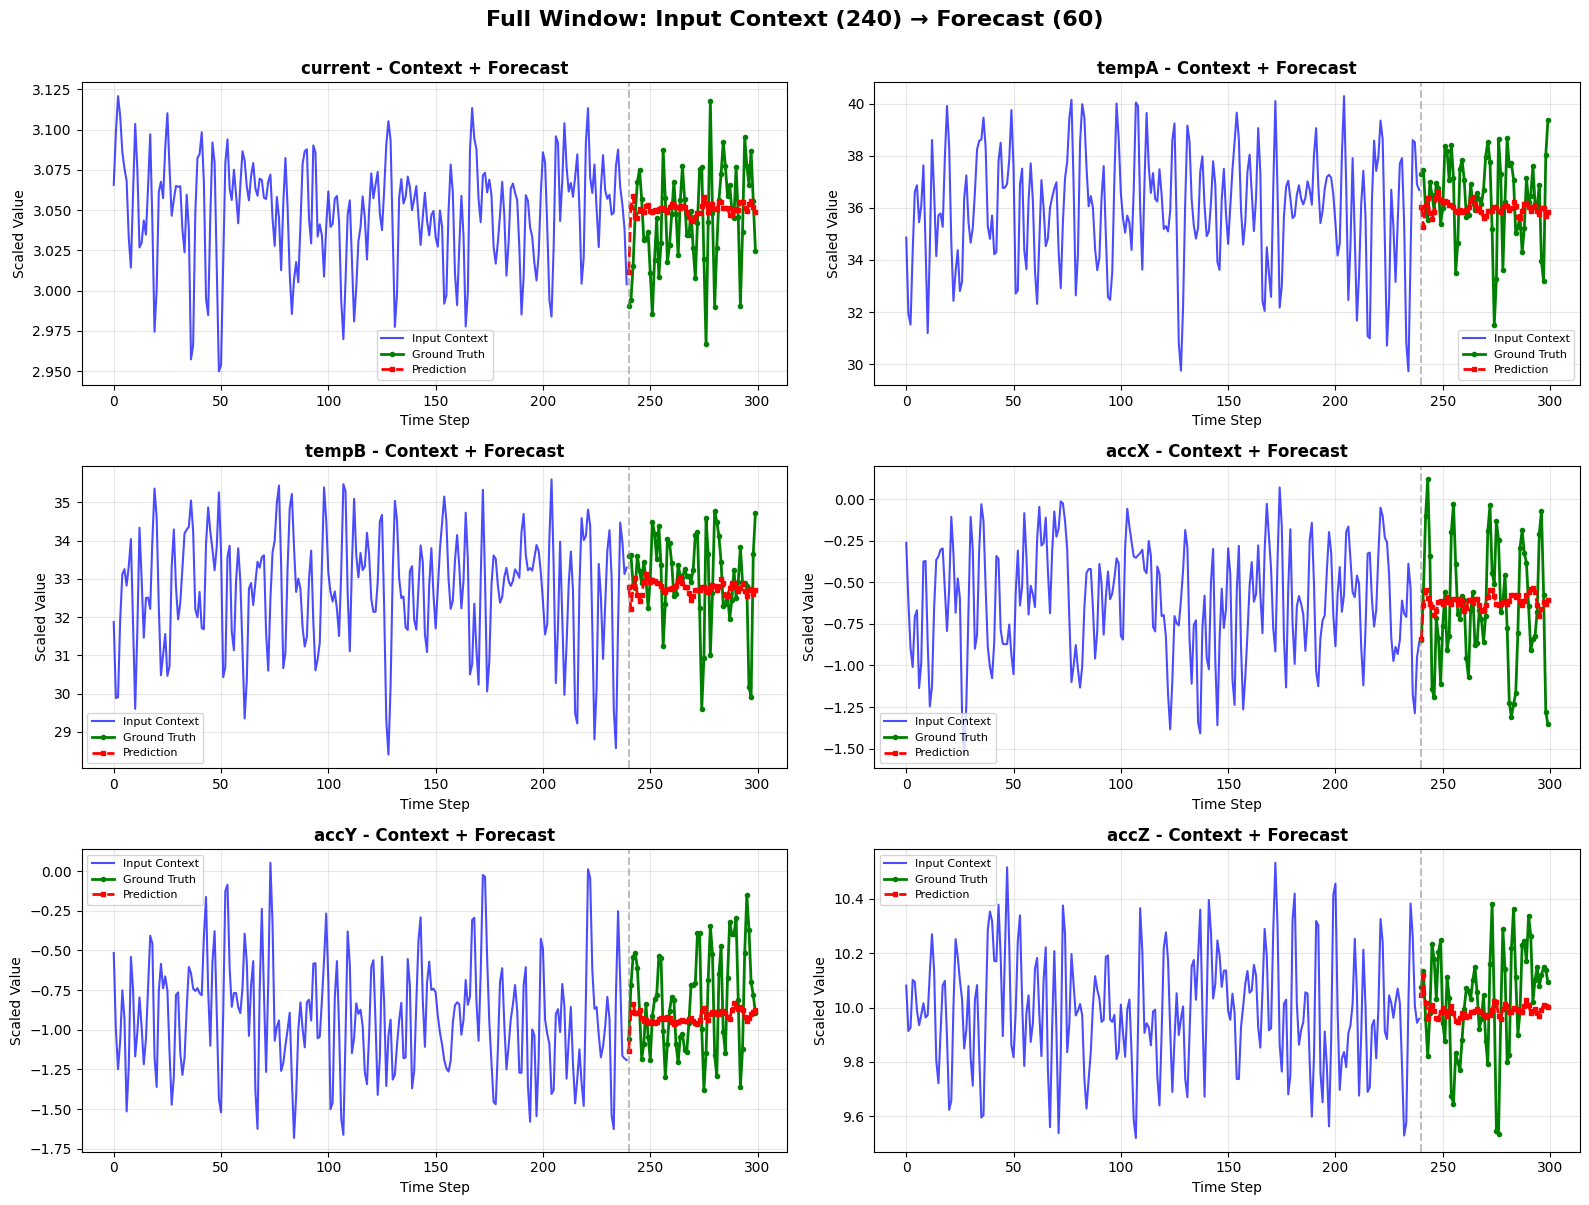


✅ Model evaluation and visualization complete!


In [28]:
# ==============================================
# LOAD TEST WINDOWS FROM DRIVE AND EVALUATE MODEL
# ==============================================

from google.colab import drive
drive.mount('/content/drive')

import os
import json
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# ✅ STEP 1: Define paths
windows_dir = "/content/drive/MyDrive/FYP/FYP-WF-8/Rextro/Models/PatchTSTs/SET-2/V4/cusloss/smoothed_windows"



# # Load scaler
# import pickle
# scaler_path = os.path.join(windows_dir, "scaler.pkl")
# with open(scaler_path, "rb") as f:
#     scaler = pickle.load(f)



print("="*80)
print("LOADING TEST WINDOWS FROM DRIVE")
print("="*80)

# ✅ STEP 2: Load metadata
metadata_path = os.path.join(windows_dir, "metadata.json")
with open(metadata_path, "r") as f:
    metadata = json.load(f)

context_length = metadata['context_length']
prediction_length = metadata['prediction_length']
num_features = metadata['num_features']
feature_cols = metadata['feature_cols']

print(f"   Context Length (saved windows): {context_length}")
print(f"   Prediction Length: {prediction_length}")
print(f"   Num Features: {num_features}")
print(f"   Feature Columns: {feature_cols}")

# 🚫 DO NOT LOAD A NEW MODEL
print("\n⚠ Using the model already trained in this notebook (NOT loading from Drive).")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# ✅ STEP 3: Load test windows
print(f"\n📦 Loading test windows...")
X_test_np = np.load(os.path.join(windows_dir, "X_test.npy"))
y_test_np = np.load(os.path.join(windows_dir, "y_test.npy"))
print(f"   X_test shape: {X_test_np.shape}")
print(f"   y_test shape: {y_test_np.shape}")

# ==============================================
# 🔍 MATCH INPUT LENGTH WITH MODEL EXPECTATION
# ==============================================
required_len = model.config.context_length
print(f"\n🔧 Model expects input length: {required_len}")

if context_length != required_len:
    print(f"⚠ Input context length ({context_length}) ≠ expected ({required_len}). Auto-adjusting...")
else:
    print("✅ Context length matches model.")

# =================================================
# EVALUATE MODEL
# =================================================
print("\n" + "="*80)
print("EVALUATING MODEL ON TEST DATA")
print("="*80)

window_idx = -2
print(f"\n📊 Evaluating on test window index: {window_idx}")

X_input = X_test_np[window_idx:window_idx+1]  # (1, context_length, features)

# 🔧 FIX: Crop input to match model expected context length
X_input = X_input[:, -required_len:, :]
y_ground_truth = y_test_np[window_idx]       # (prediction_length, features)

print(f"   Adjusted Input shape: {X_input.shape}")
print(f"   Ground truth shape: {y_ground_truth.shape}")

# Convert to tensor and make prediction
last_past = torch.from_numpy(X_input).float().to(device)

with torch.no_grad():
    out = model(past_values=last_past)

# Handle tuple output
preds = out.prediction_outputs
if isinstance(preds, tuple):
    preds = preds[0]

pred = preds.squeeze(0).cpu().numpy()
gt = y_ground_truth

print(f"\n   Prediction shape: {pred.shape}")
print(f"   Ground truth shape: {gt.shape}")


# # ✅ Inverse transform to original scale for visualization
# pred = scaler.inverse_transform(pred)
# gt = scaler.inverse_transform(gt)

print(f"\nPredictions (In Model Scale):")
print(pd.DataFrame(pred[:10], columns=feature_cols))

print(f"\nGround Truth (In Model Scale):")
print(pd.DataFrame(gt[:10], columns=feature_cols))



# ✅ STEP 6: Print prediction results
print("\n" + "="*80)
print("MODEL PREDICTIONS")
print("="*80)

timesteps_to_show = min(300, prediction_length)
print(f"\nPredictions (First {timesteps_to_show} timesteps):")
df_pred = pd.DataFrame(pred[:timesteps_to_show], columns=feature_cols)
df_pred.index.name = 'Timestep'
print(df_pred)

print(f"\nGround Truth (First {timesteps_to_show} timesteps):")
df_gt = pd.DataFrame(gt[:timesteps_to_show], columns=feature_cols)
df_gt.index.name = 'Timestep'
print(df_gt)

# ✅ STEP 7: Calculate per-feature metrics
print(f"\n📈 Per-Feature Metrics:")
metrics_list = []
for i, col in enumerate(feature_cols):
    mae = np.mean(np.abs(pred[:, i] - gt[:, i]))
    rmse = np.sqrt(np.mean((pred[:, i] - gt[:, i])**2))
    mape = np.mean(np.abs((gt[:, i] - pred[:, i]) / (np.abs(gt[:, i]) + 1e-8))) * 100

    pred_std = np.std(pred[:, i])
    gt_std = np.std(gt[:, i])
    flatness_ratio = pred_std / gt_std if gt_std > 0 else 0

    metrics_list.append({
        'Feature': col,
        'MAE': f'{mae:.6f}',
        'RMSE': f'{rmse:.6f}',
        'MAPE': f'{mape:.2f}%',
        'Pred_Std': f'{pred_std:.6f}',
        'GT_Std': f'{gt_std:.6f}',
        'Flatness_Ratio': f'{flatness_ratio:.4f}'
    })

metrics_df = pd.DataFrame(metrics_list)
print(metrics_df.to_string(index=False))

# ✅ STEP 8: Flatness check
print("\n⚠️ FLATNESS CHECK:")
for i, col in enumerate(feature_cols):
    pred_range = pred[:, i].max() - pred[:, i].min()
    gt_range = gt[:, i].max() - gt[:, i].min()
    flatness_ratio = pred_range / gt_range if gt_range > 0 else 0

    if flatness_ratio < 0.3:
        print(f"🚨 WARNING: {col} predictions are TOO FLAT!")
        print(f"   Prediction range: {pred_range:.6f}, Ground truth range: {gt_range:.6f}")
        print(f"   Flatness ratio: {flatness_ratio:.4f} (should be > 0.5)")
    else:
        print(f"✅ {col}: Flatness ratio = {flatness_ratio:.4f} (OK)")

# ✅ STEP 9: Visualization - Predictions vs Ground Truth
print("\n" + "="*80)
print("VISUALIZATION")
print("="*80)

steps_to_plot = min(100, prediction_length)
fig, axes = plt.subplots(3, 2, figsize=(16, 12), sharex=True)
axes = axes.flatten()

for i in range(num_features):
    ax = axes[i]
    ax.plot(gt[:steps_to_plot, i], label="Ground Truth", linewidth=2, marker='o', markersize=3)
    ax.plot(pred[:steps_to_plot, i], label="Forecast", linewidth=2, linestyle="--", marker='s', markersize=3)

    # Add shaded error region
    ax.fill_between(range(steps_to_plot),
                    pred[:steps_to_plot, i] - np.abs(pred[:steps_to_plot, i] - gt[:steps_to_plot, i]),
                    pred[:steps_to_plot, i] + np.abs(pred[:steps_to_plot, i] - gt[:steps_to_plot, i]),
                    alpha=0.2, color='red')

    mae = np.mean(np.abs(pred[:steps_to_plot, i] - gt[:steps_to_plot, i]))
    ax.set_title(f"{feature_cols[i]} - MAE: {mae:.4f}", fontweight='bold')
    ax.set_ylabel("Scaled value")
    ax.grid(True, alpha=0.3)
    ax.legend()

axes[-1].set_xlabel("Time steps (forecast horizon)")
plt.suptitle(f'Model Predictions vs Ground Truth (Window {window_idx}, First {steps_to_plot} steps)',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# ✅ STEP 10: Visualization - Input Context + Prediction
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for i in range(num_features):
    ax = axes[i]

    # Plot input context
    input_context = X_input[0, :, i]
    ax.plot(range(context_length), input_context,
            label='Input Context', linewidth=1.5, color='blue', alpha=0.7)

    # Plot ground truth (future)
    ax.plot(range(context_length, context_length + prediction_length), gt[:, i],
            label='Ground Truth', linewidth=2, color='green', marker='o', markersize=3)

    # Plot prediction
    ax.plot(range(context_length, context_length + prediction_length), pred[:, i],
            label='Prediction', linewidth=2, color='red', linestyle='--', marker='s', markersize=3)

    # Vertical line at forecast start
    ax.axvline(x=context_length, color='gray', linestyle='--', alpha=0.5)

    ax.set_title(f"{feature_cols[i]} - Context + Forecast", fontweight='bold')
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Scaled Value")
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Full Window: Input Context ({context_length}) → Forecast ({prediction_length})',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n✅ Model evaluation and visualization complete!")


In [29]:
# Add this after training to check what model learned:
print("\n🔍 PREDICTION VARIANCE CHECK:")
for i in range(num_features):
    pred_var = np.var(pred[:, i])
    gt_var = np.var(gt[:, i])
    print(f"{feature_cols[i]}: Pred_Var={pred_var:.6f}, GT_Var={gt_var:.6f}, Ratio={pred_var/gt_var:.4f}")


🔍 PREDICTION VARIANCE CHECK:
current: Pred_Var=0.000034, GT_Var=0.000921, Ratio=0.0373
tempA: Pred_Var=0.052727, GT_Var=2.340778, Ratio=0.0225
tempB: Pred_Var=0.025214, GT_Var=1.198951, Ratio=0.0210
accX: Pred_Var=0.002172, GT_Var=0.127561, Ratio=0.0170
accY: Pred_Var=0.001870, GT_Var=0.092836, Ratio=0.0201
accZ: Pred_Var=0.000664, GT_Var=0.035221, Ratio=0.0188


In [30]:
# # Save model and scaler

save_dir = os.path.join(model_paths, "artifacts/patchtst_sensor_multivar/")
os.makedirs(save_dir, exist_ok=True)
trainer.save_model(save_dir)

# import pickle
# with open(os.path.join(save_dir, "scaler.pkl"), "wb") as f:
#     pickle.dump(scaler, f)

# Optional: ONNX export for deployment
# !pip install onnx onnxscript
# import torch.onnx
# dummy = torch.randn(1, context_length, num_features).to(device)
# torch.onnx.export(
#     model,
#     (dummy,),
#     os.path.join(save_dir, "patchtst_forecast.onnx"),
#     input_names=["past_values"],
#     output_names=["predictions"],
#     dynamic_axes={"past_values": {0: "batch_size"}, "predictions": {0: "batch_size"}},
#     opset_version=17
# )


In [31]:
# best_model_dir = os.path.join(
#     model_paths, "checkpoints/patchtst_sensor"
# )

# # Force local loading
# model = PatchTSTForPrediction.from_pretrained(
#     best_model_dir,
#     local_files_only=True   # <-- important
# ).to(device)

# trainer.model = model


## **Model Inference**

### HuggingFace Transformer Inference

In [ ]:
import os
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import PatchTSTForPrediction
from sklearn.preprocessing import StandardScaler


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Path to your saved model artifacts
model_paths = "/content/drive/MyDrive/FYP/FYP-WF-7/Rextro/Models/PatchTSTs/SET-2/artifacts/patchtst_sensor_multivar/"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load trained PatchTST model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PatchTSTForPrediction.from_pretrained(model_paths).to(device)

# Load scaler
with open(os.path.join(model_paths, "scaler.pkl"), "rb") as f:
    scaler = pickle.load(f)


In [ ]:
import pandas as pd

csv_path = "/content/drive/MyDrive/FYP/FYP-WF-7/Rextro/1-RAW_HOURLY_DATA/minutely_sensor_dataset.csv"
df = pd.read_csv(csv_path)

# Select the same 8 features
feature_cols = df.columns[:8].tolist()
data = df[feature_cols].values.astype(np.float32)

# Scale using the loaded scaler
data_scaled = scaler.transform(data).astype(np.float32)

# Define context/prediction lengths (must match training)
context_length = 160
prediction_length = 20
num_features = data_scaled.shape[1]


In [ ]:
def build_windows(arr, context_len, pred_len):
    X_list, Y_list = [], []
    T = arr.shape[0]
    for start in range(0, T - context_len - pred_len + 1):
        end_ctx = start + context_len
        end_pred = end_ctx + pred_len
        X_list.append(arr[start:end_ctx])
        Y_list.append(arr[end_ctx:end_pred])
    X = np.stack(X_list, axis=0)
    Y = np.stack(Y_list, axis=0)
    return X.astype(np.float32), Y.astype(np.float32)

X_test_np, y_test_np = build_windows(data_scaled, context_length, prediction_length)


In [ ]:
# Forecast on the last test window
last_past = torch.from_numpy(X_test_np[-100:-99]).to(device)  # (1, L, C)
with torch.no_grad():
    out = model(past_values=last_past)

pred = out.prediction_outputs.squeeze(0).cpu().numpy()   # (T, C)
gt   = y_test_np[-100]                                     # (T, C)


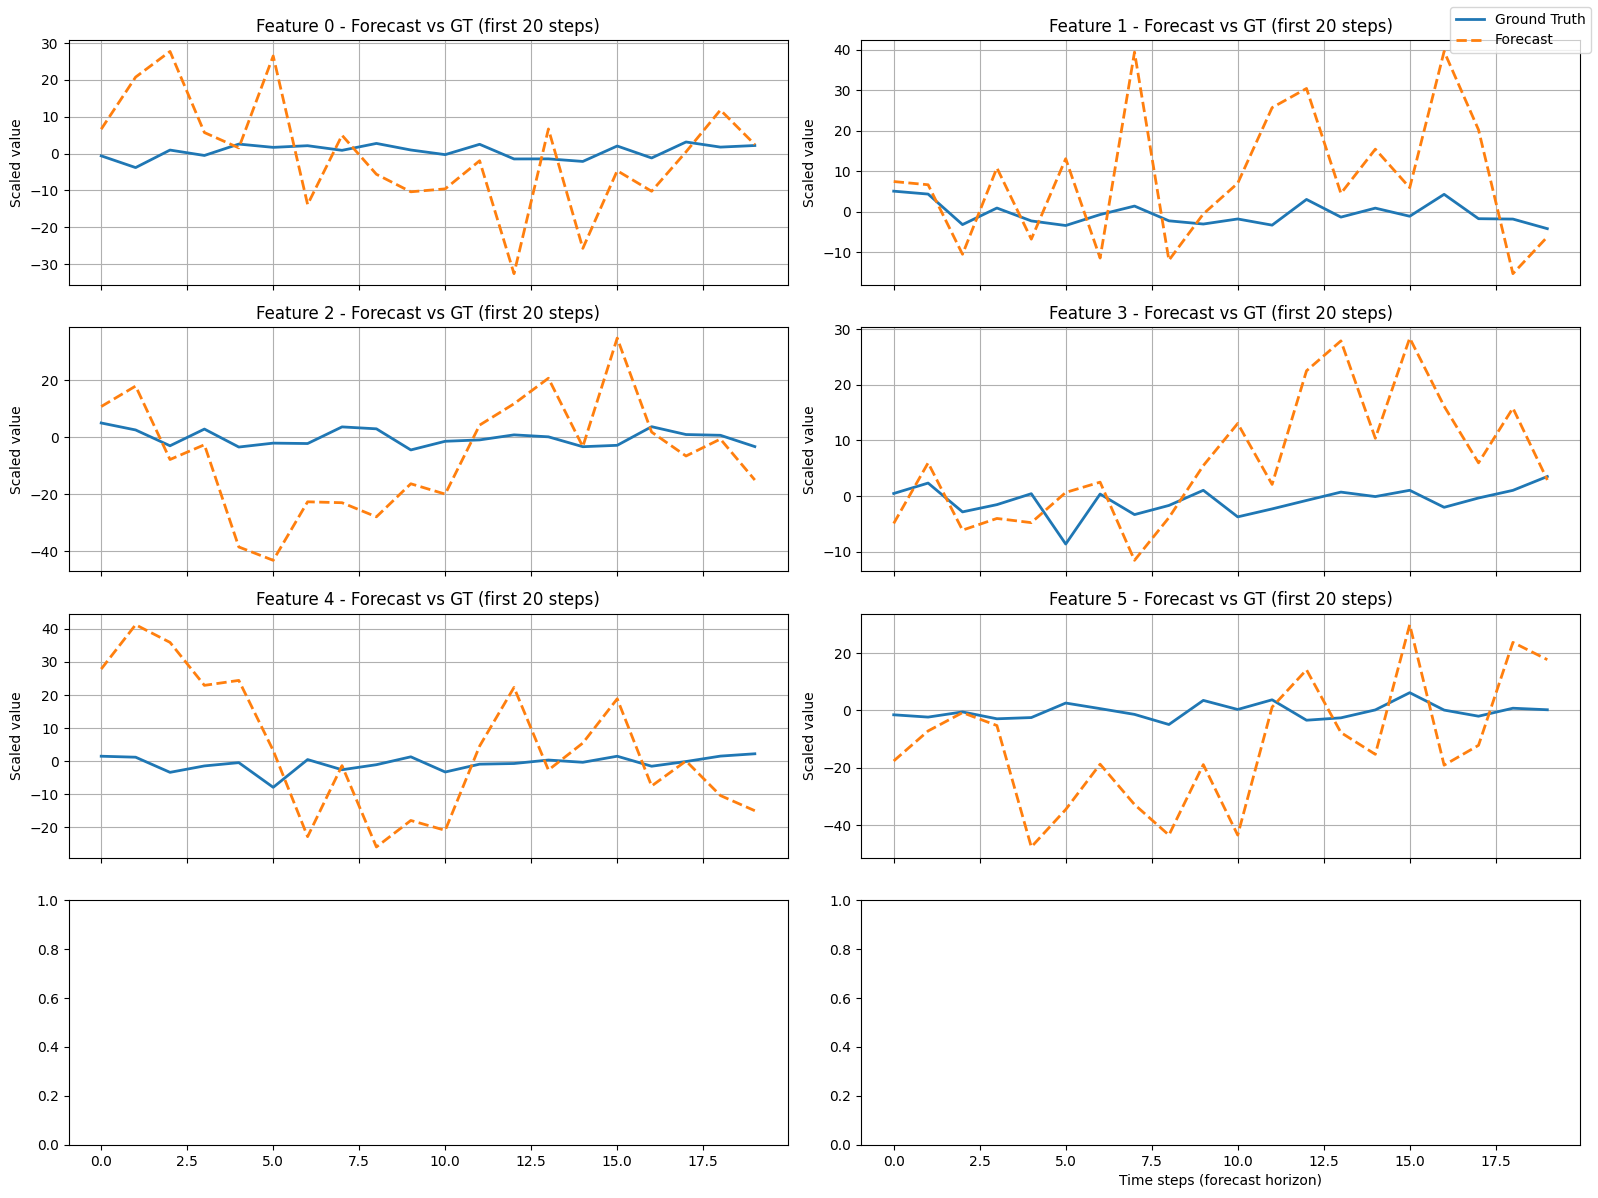

In [ ]:
steps_to_plot = min(100, prediction_length)
fig, axes = plt.subplots(4, 2, figsize=(16, 12), sharex=True)
axes = axes.flatten()

for i in range(num_features):
    ax = axes[i]
    ax.plot(gt[:steps_to_plot, i], label="Ground Truth", linewidth=2)
    ax.plot(pred[:steps_to_plot, i], label="Forecast", linewidth=2, linestyle="--")
    ax.set_title(f"Feature {i} - Forecast vs GT (first {steps_to_plot} steps)")
    ax.set_ylabel("Scaled value")
    ax.grid(True)

axes[-1].set_xlabel("Time steps (forecast horizon)")
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")
plt.tight_layout()
plt.show()


### Pytorch Transformer Inference

In [ ]:
# ==============================================
# LOAD HUGGINGFACE MODEL & SAVE AS .pt FILE
# ==============================================

from google.colab import drive
drive.mount('/content/drive')

import os
import torch
import pickle
from transformers import PatchTSTForPrediction

# Define paths
model_paths = "/content/drive/MyDrive/FYP/FYP-WF-7/Rextro/Models/PatchTSTs/SET-2/"
hf_model_dir = os.path.join(model_paths, "artifacts/patchtst_sensor_multivar/")
save_dir = os.path.join(model_paths, "artifacts/")
os.makedirs(save_dir, exist_ok=True)

print("="*80)
print("CONVERTING HUGGINGFACE MODEL TO .pt FILE")
print("="*80)

# Step 1: Load the HuggingFace model
print(f"\n1️⃣ Loading HuggingFace model from: {hf_model_dir}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    model = PatchTSTForPrediction.from_pretrained(
        hf_model_dir,
        local_files_only=True
    )
    print("✅ Model loaded successfully")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    raise

# Step 2: Load scaler (if it exists)
scaler_path = os.path.join(hf_model_dir, "scaler.pkl")
scaler = None
if os.path.exists(scaler_path):
    print(f"\n2️⃣ Loading scaler from: {scaler_path}")
    with open(scaler_path, "rb") as f:
        scaler = pickle.load(f)
    print("✅ Scaler loaded successfully")
else:
    print(f"\n⚠️  Scaler not found at: {scaler_path}")
    print("   Model will be saved without scaler")

# Step 3: Move model to CPU and set to eval mode
print("\n3️⃣ Preparing model for saving...")
model = model.cpu()
model.eval()
print("✅ Model ready for saving")

# Step 4: Save FULL model as .pt file
full_model_path = os.path.join(save_dir, "patchtst_full_model.pt")
print(f"\n4️⃣ Saving full model to: {full_model_path}")
torch.save(model, full_model_path)
print("✅ Full model saved as .pt")

# Step 5: Save scaler separately (if it exists)
if scaler is not None:
    scaler_save_path = os.path.join(save_dir, "scaler.pkl")
    with open(scaler_save_path, "wb") as f:
        pickle.dump(scaler, f)
    print(f"✅ Scaler saved to: {scaler_save_path}")

# Step 6: Verify file size
file_size_mb = os.path.getsize(full_model_path) / (1024 * 1024)
print(f"\n📊 File Info:")
print(f"   Path: {full_model_path}")
print(f"   Size: {file_size_mb:.2f} MB")
print(f"   Format: Full PyTorch model (.pt)")
print(f"   Contains: Model architecture + weights + config")

print("\n" + "="*80)
print("✅ CONVERSION COMPLETE!")
print("="*80)
print(f"\n📁 Saved files:")
print(f"   1. Model: {full_model_path}")
if scaler is not None:
    print(f"   2. Scaler: {scaler_save_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
CONVERTING HUGGINGFACE MODEL TO .pt FILE

1️⃣ Loading HuggingFace model from: /content/drive/MyDrive/FYP/FYP-WF-7/Rextro/Models/PatchTSTs/SET-2/artifacts/patchtst_sensor_multivar/
✅ Model loaded successfully

2️⃣ Loading scaler from: /content/drive/MyDrive/FYP/FYP-WF-7/Rextro/Models/PatchTSTs/SET-2/artifacts/patchtst_sensor_multivar/scaler.pkl
✅ Scaler loaded successfully

3️⃣ Preparing model for saving...
✅ Model ready for saving

4️⃣ Saving full model to: /content/drive/MyDrive/FYP/FYP-WF-7/Rextro/Models/PatchTSTs/SET-2/artifacts/patchtst_full_model.pt
✅ Full model saved as .pt
✅ Scaler saved to: /content/drive/MyDrive/FYP/FYP-WF-7/Rextro/Models/PatchTSTs/SET-2/artifacts/scaler.pkl

📊 File Info:
   Path: /content/drive/MyDrive/FYP/FYP-WF-7/Rextro/Models/PatchTSTs/SET-2/artifacts/patchtst_full_model.pt
   Size: 49.83 MB
   Format: Full PyTorch model (.pt)
  

In [ ]:
# ==============================================
# LOAD MODEL FROM .pt FILE
# ==============================================

from google.colab import drive
drive.mount('/content/drive')

import torch
import pickle
import os

# Path to saved model
model_paths = "/content/drive/MyDrive/FYP/FYP-WF-7/Rextro/Models/PatchTSTs/SET-2/"
model_path = os.path.join(model_paths, "artifacts/patchtst_full_model.pt")
scaler_path = os.path.join(model_paths, "artifacts/scaler.pkl")

print("="*80)
print("LOADING MODEL FROM .pt FILE")
print("="*80)

# Step 1: Load model
print(f"\n1️⃣ Loading model from: {model_path}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    # Load with weights_only=False for PyTorch 2.6+
    model = torch.load(model_path, map_location=device, weights_only=False)
    model.to(device)
    model.eval()
    print("✅ Model loaded successfully!")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    raise

# Step 2: Load scaler (if needed)
if os.path.exists(scaler_path):
    print(f"\n2️⃣ Loading scaler from: {scaler_path}")
    with open(scaler_path, "rb") as f:
        scaler = pickle.load(f)
    print("✅ Scaler loaded successfully!")
else:
    print(f"\n⚠️  Scaler not found at: {scaler_path}")
    scaler = None

# Step 3: Model info
print(f"\n📊 Model Info:")
print(f"   Device: {device}")
print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Step 4: Test inference
print(f"\n🧪 Testing inference...")
import numpy as np
dummy_input = torch.randn(1, 160, 6).to(device)  # Adjust shape as needed

with torch.no_grad():
    output = model(past_values=dummy_input)
    preds = output.prediction_outputs
    if isinstance(preds, tuple):
        preds = preds[0]
    print(f"   Input shape: {dummy_input.shape}")
    print(f"   Output shape: {preds.shape}")

print("\n" + "="*80)
print("✅ MODEL READY FOR INFERENCE!")
print("="*80)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
LOADING MODEL FROM .pt FILE

1️⃣ Loading model from: /content/drive/MyDrive/FYP/FYP-WF-7/Rextro/Models/PatchTSTs/SET-2/artifacts/patchtst_full_model.pt
✅ Model loaded successfully!

2️⃣ Loading scaler from: /content/drive/MyDrive/FYP/FYP-WF-7/Rextro/Models/PatchTSTs/SET-2/artifacts/scaler.pkl
✅ Scaler loaded successfully!

📊 Model Info:
   Device: cpu
   Parameters: 13,031,956

🧪 Testing inference...
   Input shape: torch.Size([1, 160, 6])
   Output shape: torch.Size([1, 20, 6])

✅ MODEL READY FOR INFERENCE!


# Next

In [32]:
# ==============================================
# COMPLETE STANDALONE INFERENCE & VISUALIZATION
# ==============================================

from google.colab import drive
drive.mount('/content/drive')

import os
import json
import pickle
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from scipy import stats

# ==============================================
# CONFIGURATION - Update these paths as needed
# ==============================================

# Path to saved windows and model
windows_dir = "/content/drive/MyDrive/FYP/FYP-WF-8/Rextro/Models/PatchTSTs/SET-2/V4/cusloss/smoothed_windows"
model_dir = "/content/drive/MyDrive/FYP/FYP-WF-8/Rextro/Models/PatchTSTs/SET-2/V4/cusloss/artifacts/patchtst_sensor_multivar/"

# For local testing (Windows paths)
# windows_dir = r"D:\Rextro\FYP_Training\mae\1.X-std\smoothed_windows"
# model_dir = r"D:\Rextro\FYP_Training\mae\1.X-std\artifacts\patchtst_sensor_multivar"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
print("="*80)
print("PATCHTST INFERENCE WITH PROPER SCALING")
print("="*80)

# ==============================================
# STEP 1: LOAD METADATA AND WINDOWS
# ==============================================

print("\n📦 STEP 1: Loading saved windows and metadata...")

# Load metadata
metadata_path = os.path.join(windows_dir, "metadata.json")
with open(metadata_path, "r") as f:
    metadata = json.load(f)

context_length = metadata['context_length']
prediction_length = metadata['prediction_length']
num_features = metadata['num_features']
feature_cols = metadata['feature_cols']

print(f"   Context Length: {context_length}")
print(f"   Prediction Length: {prediction_length}")
print(f"   Num Features: {num_features}")
print(f"   Features: {feature_cols}")

# Load test windows
X_test_np = np.load(os.path.join(windows_dir, "X_test.npy"))
y_test_np = np.load(os.path.join(windows_dir, "y_test.npy"))
print(f"   X_test shape: {X_test_np.shape}")
print(f"   y_test shape: {y_test_np.shape}")

# Load scaler (for potential inverse transform later)
scaler_path = os.path.join(windows_dir, "scaler.pkl")
scaler = None
if os.path.exists(scaler_path):
    with open(scaler_path, "rb") as f:
        scaler = pickle.load(f)
    print(f"   ✅ Scaler loaded")
else:
    print(f"   ⚠️ Scaler not found")


PATCHTST INFERENCE WITH PROPER SCALING

📦 STEP 1: Loading saved windows and metadata...
   Context Length: 240
   Prediction Length: 60
   Num Features: 6
   Features: ['current', 'tempA', 'tempB', 'accX', 'accY', 'accZ']
   X_test shape: (6701, 240, 6)
   y_test shape: (6701, 60, 6)
   ⚠️ Scaler not found


In [34]:
# ==============================================
# STEP 2: LOAD MODEL
# ==============================================

print("\n🤖 STEP 2: Loading trained model...")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"   Device: {device}")

from transformers import PatchTSTForPrediction

try:
    model = PatchTSTForPrediction.from_pretrained(model_dir, local_files_only=True)
    model.to(device)
    model.eval()
    print(f"   ✅ Model loaded successfully")
    print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")
except Exception as e:
    print(f"   ❌ Error loading model: {e}")
    raise

# ==============================================
# STEP 3: SELECT TEST WINDOW AND GET RAW PREDICTIONS
# ==============================================

print("\n🔮 STEP 3: Getting raw predictions...")

# Select a test window (use different indices to test various samples)
window_idx = -50  # 50th from the end

# Get input context and ground truth
X_input = X_test_np[window_idx:window_idx+1]  # (1, context_length, features)
y_ground_truth = y_test_np[window_idx]         # (prediction_length, features)
input_context = X_input[0]                      # (context_length, features)

print(f"   Window index: {window_idx}")
print(f"   Input shape: {X_input.shape}")
print(f"   Ground truth shape: {y_ground_truth.shape}")

# Make prediction
input_tensor = torch.from_numpy(X_input).float().to(device)

with torch.no_grad():
    outputs = model(past_values=input_tensor)
    raw_predictions = outputs.prediction_outputs

    if isinstance(raw_predictions, tuple):
        raw_predictions = raw_predictions[0]

    raw_pred = raw_predictions.squeeze(0).cpu().numpy()  # (prediction_length, features)

print(f"   Raw prediction shape: {raw_pred.shape}")



🤖 STEP 2: Loading trained model...
   Device: cuda
   ✅ Model loaded successfully
   Parameters: 1,945,916

🔮 STEP 3: Getting raw predictions...
   Window index: -50
   Input shape: (1, 240, 6)
   Ground truth shape: (60, 6)
   Raw prediction shape: (60, 6)


In [35]:
# ==============================================
# STEP 4: ANALYZE THE SCALING PROBLEM
# ==============================================

print("\n📊 STEP 4: Analyzing scaling discrepancy...")

print("\n   Input Context Statistics:")
for i, col in enumerate(feature_cols):
    ctx_data = input_context[:, i]
    print(f"     {col:10s}: mean={ctx_data.mean():+8.4f}, std={ctx_data.std():6.4f}, "
          f"range=[{ctx_data.min():+.4f}, {ctx_data.max():+.4f}]")

print("\n   Ground Truth (Target) Statistics:")
for i, col in enumerate(feature_cols):
    gt_data = y_ground_truth[:, i]
    print(f"     {col:10s}: mean={gt_data.mean():+8.4f}, std={gt_data.std():6.4f}, "
          f"range=[{gt_data.min():+.4f}, {gt_data.max():+.4f}]")

print("\n   Raw Prediction Statistics (BEFORE SCALING):")
for i, col in enumerate(feature_cols):
    pred_data = raw_pred[:, i]
    print(f"     {col:10s}: mean={pred_data.mean():+8.4f}, std={pred_data.std():6.4f}, "
          f"range=[{pred_data.min():+.4f}, {pred_data.max():+.4f}]")



📊 STEP 4: Analyzing scaling discrepancy...

   Input Context Statistics:
     current   : mean= +3.0487, std=0.0330, range=[+2.9499, +3.1209]
     tempA     : mean=+36.0529, std=2.0518, range=[+29.7510, +40.1438]
     tempB     : mean=+32.7867, std=1.3634, range=[+28.4045, +35.4758]
     accX      : mean= -0.5984, std=0.3241, range=[-1.5361, +0.0712]
     accY      : mean= -0.8963, std=0.3465, range=[-1.6818, +0.0525]
     accZ      : mean= +9.9987, std=0.1992, range=[+9.5200, +10.5332]

   Ground Truth (Target) Statistics:
     current   : mean= +3.0498, std=0.0308, range=[+2.9839, +3.1134]
     tempA     : mean=+35.8470, std=2.2914, range=[+29.7270, +40.2843]
     tempB     : mean=+32.7121, std=1.5539, range=[+28.5740, +35.6008]
     accX      : mean= -0.6264, std=0.3170, range=[-1.2863, +0.1192]
     accY      : mean= -0.9797, std=0.3493, range=[-1.6258, +0.0115]
     accZ      : mean= +9.9756, std=0.2110, range=[+9.5290, +10.4562]

   Raw Prediction Statistics (BEFORE SCALING):
  

In [36]:
# ==============================================
# STEP 5: SCALE PREDICTIONS TO MATCH INPUT CONTEXT
# ==============================================

print("\n🔧 STEP 5: Scaling predictions to match input context...")

def scale_predictions_to_context(predictions, context, method='robust'):
    """
    Scale predictions to match the statistical properties of the input context.

    Parameters:
    -----------
    predictions : np.array (prediction_length, features)
        Raw model predictions
    context : np.array (context_length, features)
        Input context window
    method : str
        'zscore' - Match mean and std
        'robust' - Use median and IQR (more robust to outliers)
        'minmax' - Scale to context min/max range

    Returns:
    --------
    scaled_predictions : np.array
        Predictions scaled to match context statistics
    """
    scaled = np.zeros_like(predictions)
    num_features = predictions.shape[1]

    for i in range(num_features):
        pred_col = predictions[:, i]
        ctx_col = context[:, i]

        if method == 'zscore':
            # Z-score scaling: match mean and std
            pred_mean = pred_col.mean()
            pred_std = pred_col.std()
            ctx_mean = ctx_col.mean()
            ctx_std = ctx_col.std()

            if pred_std > 1e-8:
                # Standardize predictions, then scale to context
                standardized = (pred_col - pred_mean) / pred_std
                scaled[:, i] = standardized * ctx_std + ctx_mean
            else:
                scaled[:, i] = np.full_like(pred_col, ctx_mean)

        elif method == 'robust':
            # Robust scaling using median and IQR
            pred_median = np.median(pred_col)
            pred_iqr = np.percentile(pred_col, 75) - np.percentile(pred_col, 25)
            ctx_median = np.median(ctx_col)
            ctx_iqr = np.percentile(ctx_col, 75) - np.percentile(ctx_col, 25)

            if pred_iqr > 1e-8:
                # Scale using robust statistics
                robust_scaled = (pred_col - pred_median) / pred_iqr
                scaled[:, i] = robust_scaled * ctx_iqr + ctx_median
            else:
                scaled[:, i] = np.full_like(pred_col, ctx_median)

        elif method == 'minmax':
            # Min-max scaling to context range
            pred_min = pred_col.min()
            pred_max = pred_col.max()
            ctx_min = ctx_col.min()
            ctx_max = ctx_col.max()

            if (pred_max - pred_min) > 1e-8:
                normalized = (pred_col - pred_min) / (pred_max - pred_min)
                scaled[:, i] = normalized * (ctx_max - ctx_min) + ctx_min
            else:
                scaled[:, i] = np.full_like(pred_col, (ctx_max + ctx_min) / 2)

    return scaled


def remove_prediction_outliers(predictions, threshold=3.0):
    """
    Remove/replace outliers in predictions using Z-score method.

    Parameters:
    -----------
    predictions : np.array (prediction_length, features)
        Model predictions
    threshold : float
        Z-score threshold for outlier detection

    Returns:
    --------
    cleaned_predictions : np.array
        Predictions with outliers replaced by interpolated values
    outlier_info : dict
        Information about detected outliers
    """
    cleaned = predictions.copy()
    outlier_info = {}

    for i in range(predictions.shape[1]):
        col = predictions[:, i]

        # Calculate Z-scores
        mean = np.mean(col)
        std = np.std(col)

        if std > 1e-8:
            z_scores = np.abs((col - mean) / std)
            outlier_mask = z_scores > threshold
            num_outliers = np.sum(outlier_mask)

            if num_outliers > 0:
                # Replace outliers with interpolated values
                col_cleaned = col.copy()
                col_cleaned[outlier_mask] = np.nan

                # Linear interpolation
                nans = np.isnan(col_cleaned)
                x = np.arange(len(col_cleaned))

                if np.sum(~nans) >= 2:  # Need at least 2 points for interpolation
                    col_cleaned[nans] = np.interp(x[nans], x[~nans], col_cleaned[~nans])
                else:
                    col_cleaned[nans] = mean

                cleaned[:, i] = col_cleaned
                outlier_info[i] = {
                    'count': num_outliers,
                    'indices': np.where(outlier_mask)[0].tolist()
                }
            else:
                outlier_info[i] = {'count': 0, 'indices': []}
        else:
            outlier_info[i] = {'count': 0, 'indices': []}

    return cleaned, outlier_info


# Step 5a: Remove outliers from raw predictions
print("\n   5a. Removing outliers from raw predictions...")
pred_no_outliers, outlier_info = remove_prediction_outliers(raw_pred, threshold=3.0)

for i, col in enumerate(feature_cols):
    if outlier_info[i]['count'] > 0:
        print(f"       {col}: {outlier_info[i]['count']} outliers removed")
    else:
        print(f"       {col}: No outliers detected")

# Step 5b: Scale predictions using different methods
print("\n   5b. Scaling predictions to match input context...")

scaled_zscore = scale_predictions_to_context(pred_no_outliers, input_context, method='zscore')
scaled_robust = scale_predictions_to_context(pred_no_outliers, input_context, method='robust')
scaled_minmax = scale_predictions_to_context(pred_no_outliers, input_context, method='minmax')

print("\n   Scaled Prediction Statistics (Z-Score Method):")
for i, col in enumerate(feature_cols):
    pred_data = scaled_zscore[:, i]
    gt_data = y_ground_truth[:, i]
    print(f"     {col:10s}: pred_range=[{pred_data.min():+.4f}, {pred_data.max():+.4f}], "
          f"gt_range=[{gt_data.min():+.4f}, {gt_data.max():+.4f}]")



🔧 STEP 5: Scaling predictions to match input context...

   5a. Removing outliers from raw predictions...
       current: 2 outliers removed
       tempA: 1 outliers removed
       tempB: 1 outliers removed
       accX: 1 outliers removed
       accY: 1 outliers removed
       accZ: 1 outliers removed

   5b. Scaling predictions to match input context...

   Scaled Prediction Statistics (Z-Score Method):
     current   : pred_range=[+2.9676, +3.0941], gt_range=[+2.9839, +3.1134]
     tempA     : pred_range=[+32.4927, +42.3829], gt_range=[+29.7270, +40.2843]
     tempB     : pred_range=[+30.0643, +37.1888], gt_range=[+28.5740, +35.6008]
     accX      : pred_range=[-1.3170, +0.6119], gt_range=[-1.2863, +0.1192]
     accY      : pred_range=[-1.7410, +0.4931], gt_range=[-1.6258, +0.0115]
     accZ      : pred_range=[+9.1099, +10.3628], gt_range=[+9.5290, +10.4562]



📈 STEP 6: Visualizing outlier removal...


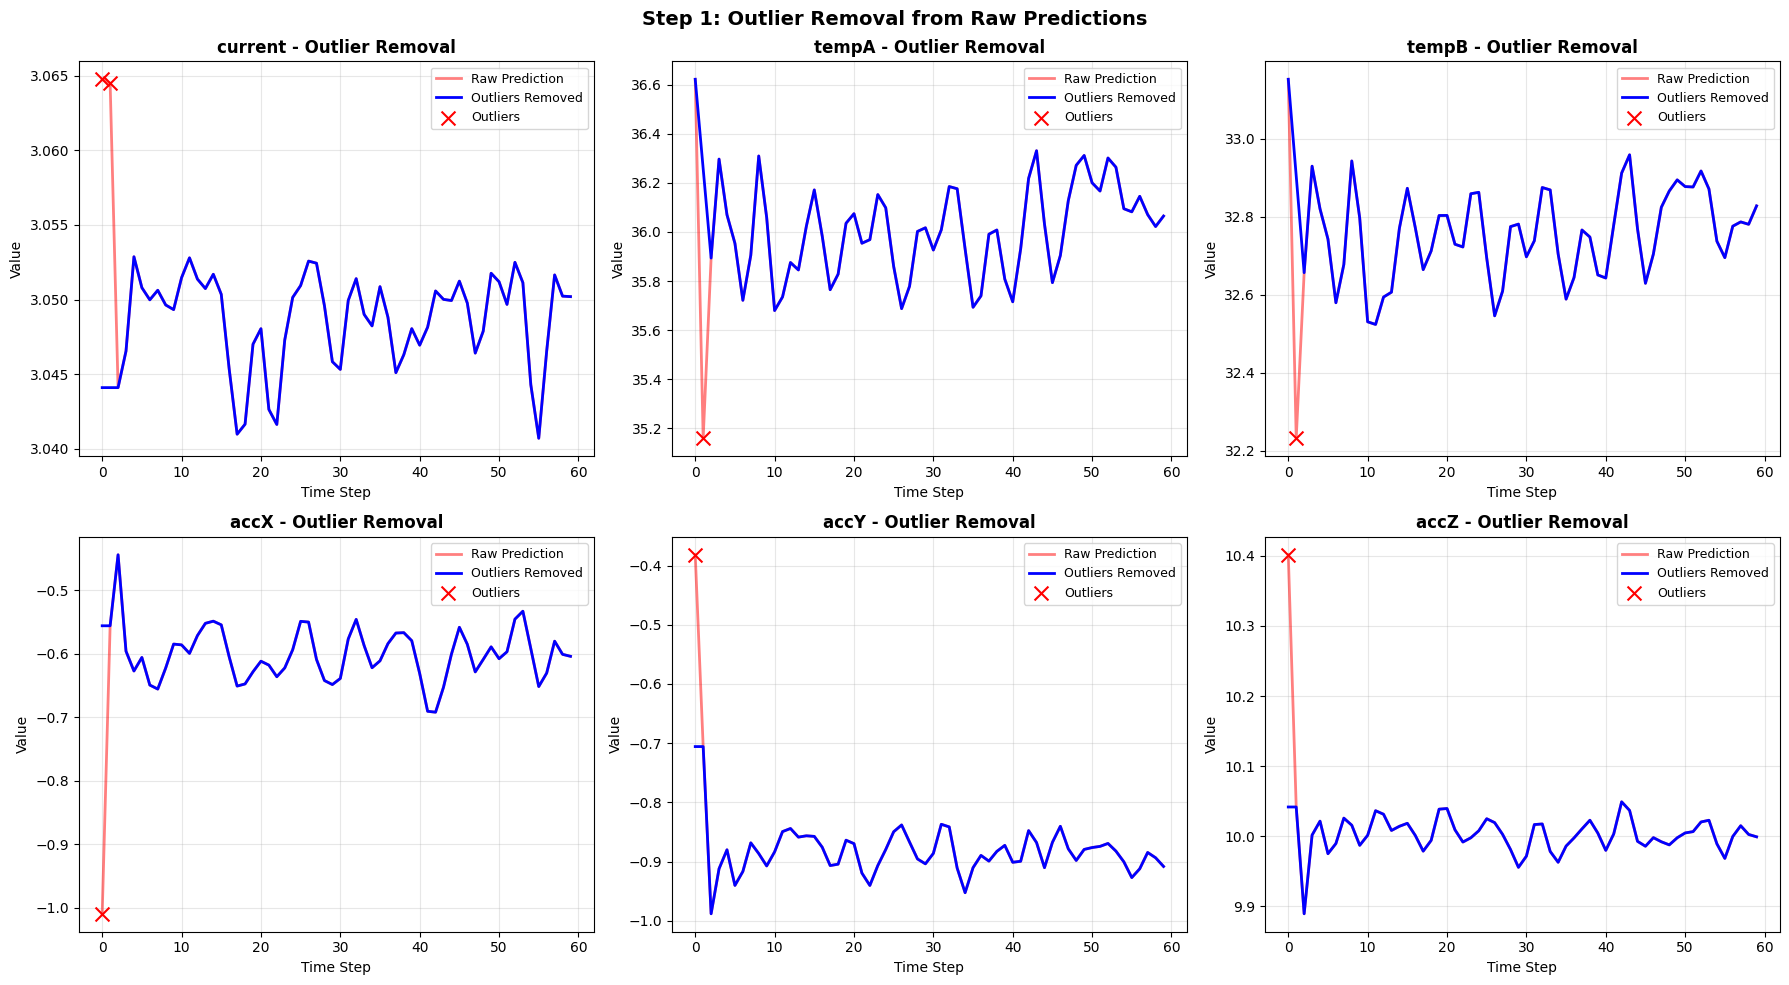

In [37]:
# ==============================================
# STEP 6: VISUALIZE OUTLIER REMOVAL
# ==============================================

print("\n📈 STEP 6: Visualizing outlier removal...")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(feature_cols):
    ax = axes[i]

    x = np.arange(prediction_length)

    # Raw predictions
    ax.plot(x, raw_pred[:, i], 'r-', linewidth=2, alpha=0.5, label='Raw Prediction')

    # After outlier removal
    ax.plot(x, pred_no_outliers[:, i], 'b-', linewidth=2, label='Outliers Removed')

    # Mark outlier positions
    if outlier_info[i]['count'] > 0:
        outlier_indices = outlier_info[i]['indices']
        ax.scatter(outlier_indices, raw_pred[outlier_indices, i],
                   c='red', s=100, zorder=5, marker='x', label='Outliers')

    ax.set_title(f'{col} - Outlier Removal', fontsize=12, fontweight='bold')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Value')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Step 1: Outlier Removal from Raw Predictions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()



📈 STEP 7: Visualizing scaling methods comparison...


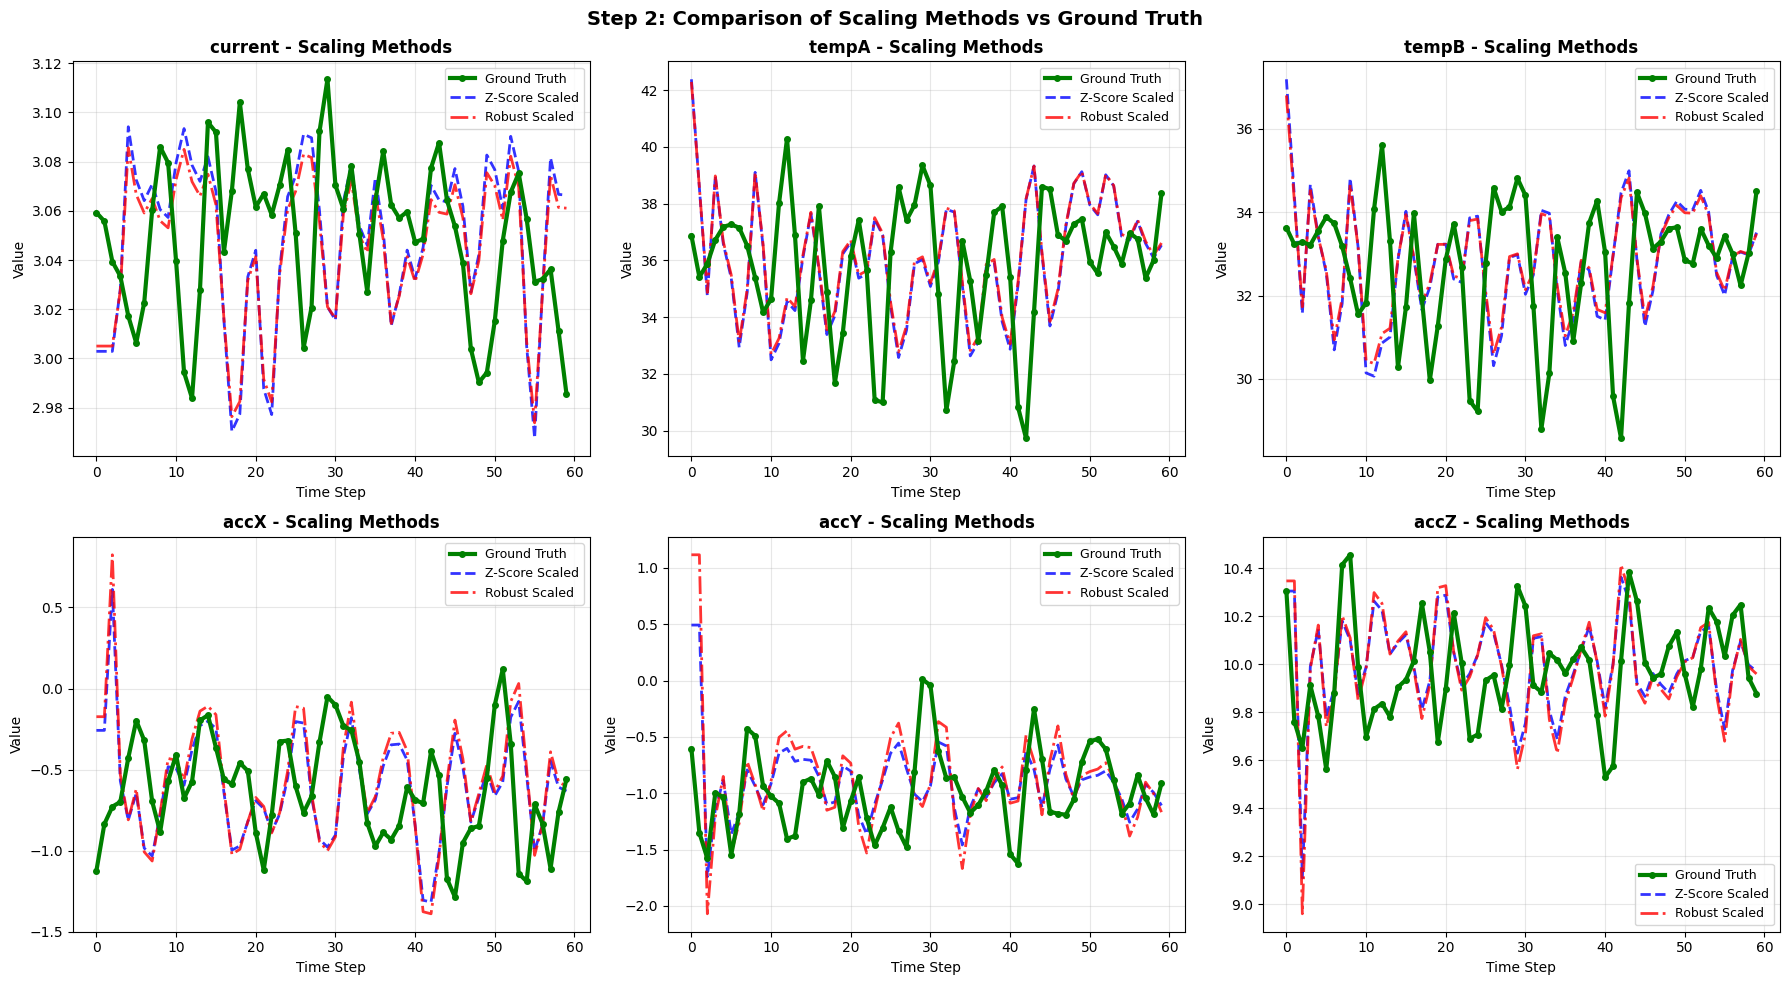

In [46]:
# ==============================================
# STEP 7: VISUALIZE SCALING COMPARISON
# ==============================================

print("\n📈 STEP 7: Visualizing scaling methods comparison...")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(feature_cols):
    ax = axes[i]

    x = np.arange(prediction_length)

    # Ground truth
    ax.plot(x, y_ground_truth[:, i], 'g-', linewidth=3, marker='o', markersize=4,
            label='Ground Truth', zorder=5)

    # Different scaling methods
    ax.plot(x, scaled_zscore[:, i], 'b--', linewidth=2, alpha=0.8, label='Z-Score Scaled')
    ax.plot(x, scaled_robust[:, i], 'r-.', linewidth=2, alpha=0.8, label='Robust Scaled')
    # ax.plot(x, scaled_minmax[:, i], 'm:', linewidth=2, alpha=0.8, label='MinMax Scaled')

    ax.set_title(f'{col} - Scaling Methods', fontsize=12, fontweight='bold')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Value')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Step 2: Comparison of Scaling Methods vs Ground Truth', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()



📈 STEP 8: Final visualization with context + scaled predictions...


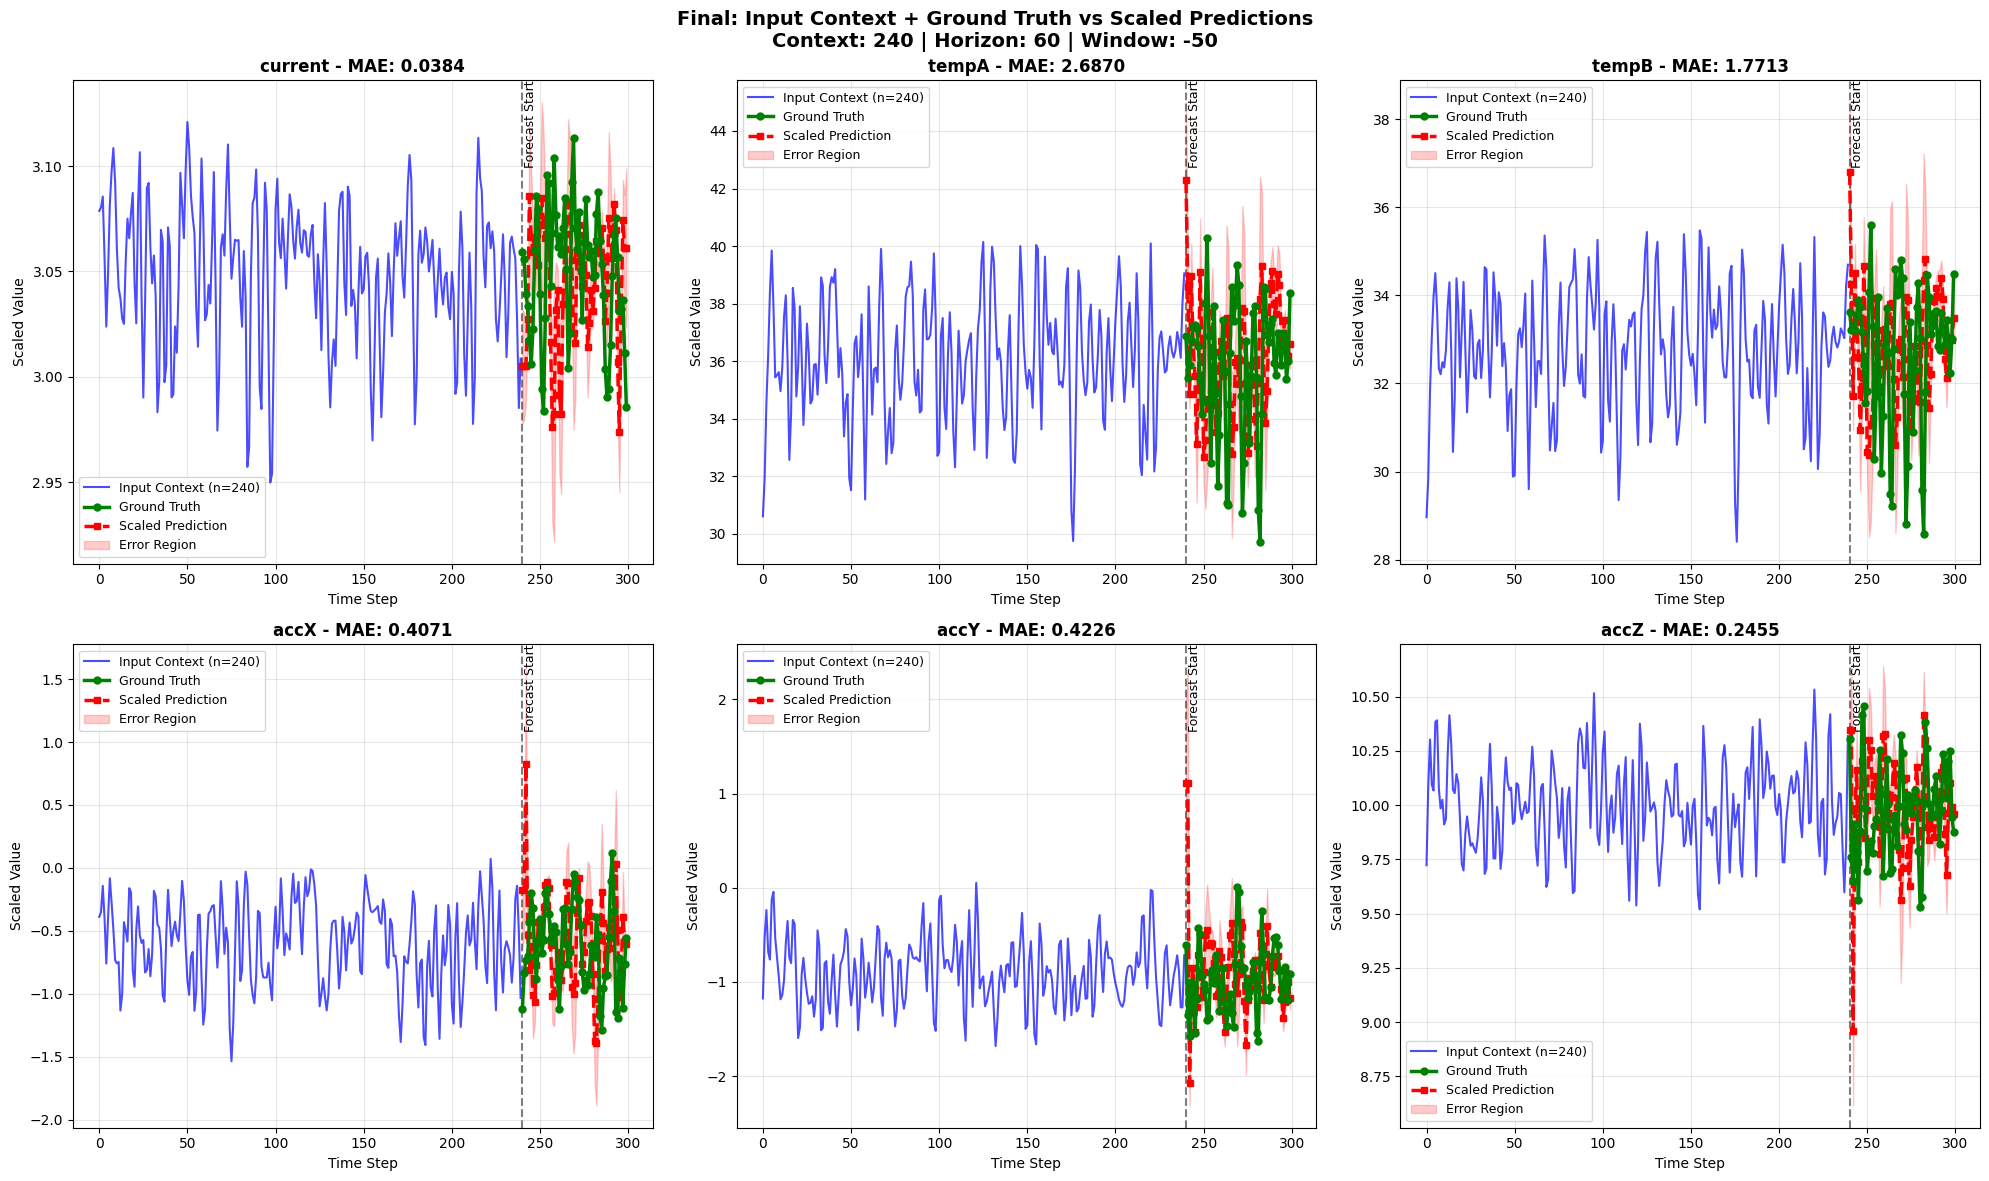


FINAL METRICS SUMMARY

📊 Per-Feature Metrics (After Scaling):

   current:
     MAE:          0.0384
     RMSE:         0.0476
     Correlation:  -0.2496
     Variance Ratio: 0.8986 (ideal: 1.0)
     Range Ratio:  0.8626 (ideal: 1.0)

   tempA:
     MAE:          2.6870
     RMSE:         3.2725
     Correlation:  -0.1537
     Variance Ratio: 0.7557 (ideal: 1.0)
     Range Ratio:  0.9094 (ideal: 1.0)

   tempB:
     MAE:          1.7713
     RMSE:         2.2339
     Correlation:  -0.2737
     Variance Ratio: 0.6278 (ideal: 1.0)
     Range Ratio:  0.9156 (ideal: 1.0)

   accX:
     MAE:          0.4071
     RMSE:         0.5253
     Correlation:  -0.1404
     Variance Ratio: 1.3782 (ideal: 1.0)
     Range Ratio:  1.5756 (ideal: 1.0)

   accY:
     MAE:          0.4226
     RMSE:         0.5856
     Correlation:  0.1059
     Variance Ratio: 2.0023 (ideal: 1.0)
     Range Ratio:  1.9464 (ideal: 1.0)

   accZ:
     MAE:          0.2455
     RMSE:         0.2998
     Correlation:  0.0855


In [39]:
# ==============================================
# STEP 8: FINAL VISUALIZATION - CONTEXT + FORECAST
# ==============================================

print("\n📈 STEP 8: Final visualization with context + scaled predictions...")

# Choose the best scaling method (typically robust or zscore works best)
final_scaled_pred = scaled_robust  # You can change this to scaled_zscore or scaled_minmax

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, col in enumerate(feature_cols):
    ax = axes[i]

    # Time axis
    ctx_x = np.arange(context_length)
    pred_x = np.arange(context_length, context_length + prediction_length)

    # Plot input context
    ax.plot(ctx_x, input_context[:, i], 'b-', linewidth=1.5, alpha=0.7,
            label=f'Input Context (n={context_length})')

    # Plot ground truth horizon
    ax.plot(pred_x, y_ground_truth[:, i], 'g-', linewidth=2.5, marker='o', markersize=5,
            label='Ground Truth', zorder=5)

    # Plot scaled predictions
    ax.plot(pred_x, final_scaled_pred[:, i], 'r--', linewidth=2.5, marker='s', markersize=5,
            label='Scaled Prediction', zorder=4)

    # Add shaded error region
    error = np.abs(final_scaled_pred[:, i] - y_ground_truth[:, i])
    ax.fill_between(pred_x,
                    final_scaled_pred[:, i] - error/2,
                    final_scaled_pred[:, i] + error/2,
                    alpha=0.2, color='red', label='Error Region')

    # Vertical line at forecast start
    ax.axvline(x=context_length, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
    ax.text(context_length + 1, ax.get_ylim()[1], 'Forecast Start',
            fontsize=9, rotation=90, va='top')

    # Calculate MAE for this feature
    mae = np.mean(np.abs(final_scaled_pred[:, i] - y_ground_truth[:, i]))

    ax.set_title(f'{col} - MAE: {mae:.4f}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Scaled Value')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Final: Input Context + Ground Truth vs Scaled Predictions\n'
             f'Context: {context_length} | Horizon: {prediction_length} | Window: {window_idx}',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ==============================================
# STEP 9: METRICS SUMMARY
# ==============================================

print("\n" + "="*80)
print("FINAL METRICS SUMMARY")
print("="*80)

print("\n📊 Per-Feature Metrics (After Scaling):")
metrics_list = []

for i, col in enumerate(feature_cols):
    gt = y_ground_truth[:, i]
    pred = final_scaled_pred[:, i]

    mae = np.mean(np.abs(pred - gt))
    rmse = np.sqrt(np.mean((pred - gt)**2))

    # Correlation coefficient
    if np.std(pred) > 1e-8 and np.std(gt) > 1e-8:
        corr = np.corrcoef(pred, gt)[0, 1]
    else:
        corr = 0.0

    # Variance ratio
    pred_var = np.var(pred)
    gt_var = np.var(gt)
    var_ratio = pred_var / gt_var if gt_var > 1e-8 else 0.0

    # Range match ratio
    pred_range = pred.max() - pred.min()
    gt_range = gt.max() - gt.min()
    range_ratio = pred_range / gt_range if gt_range > 1e-8 else 0.0

    metrics_list.append({
        'Feature': col,
        'MAE': mae,
        'RMSE': rmse,
        'Correlation': corr,
        'Var_Ratio': var_ratio,
        'Range_Ratio': range_ratio
    })

    print(f"\n   {col}:")
    print(f"     MAE:          {mae:.4f}")
    print(f"     RMSE:         {rmse:.4f}")
    print(f"     Correlation:  {corr:.4f}")
    print(f"     Variance Ratio: {var_ratio:.4f} (ideal: 1.0)")
    print(f"     Range Ratio:  {range_ratio:.4f} (ideal: 1.0)")

# Summary table
metrics_df = pd.DataFrame(metrics_list)
print("\n" + "="*80)
print("SUMMARY TABLE")
print("="*80)
print(metrics_df.to_string(index=False, float_format='%.4f'))


In [40]:
# ==============================================
# STEP 10: MULTI-WINDOW EVALUATION
# ==============================================

print("\n" + "="*80)
print("STEP 10: Multi-Window Evaluation (Stability Check)")
print("="*80)

# Test on multiple windows
test_indices = [-10, -30, -50, -70, -100]
all_maes = {col: [] for col in feature_cols}

print("\n   Testing on multiple windows...")

for idx in test_indices:
    X_in = X_test_np[idx:idx+1]
    y_gt = y_test_np[idx]
    ctx = X_in[0]

    # Predict
    input_t = torch.from_numpy(X_in).float().to(device)
    with torch.no_grad():
        out = model(past_values=input_t)
        pred = out.prediction_outputs
        if isinstance(pred, tuple):
            pred = pred[0]
        pred = pred.squeeze(0).cpu().numpy()

    # Remove outliers and scale
    pred_clean, _ = remove_prediction_outliers(pred, threshold=3.0)
    pred_scaled = scale_predictions_to_context(pred_clean, ctx, method='robust')

    # Calculate MAE
    for i, col in enumerate(feature_cols):
        mae = np.mean(np.abs(pred_scaled[:, i] - y_gt[:, i]))
        all_maes[col].append(mae)

print("\n   Per-Feature Average MAE across windows:")
for col in feature_cols:
    avg_mae = np.mean(all_maes[col])
    std_mae = np.std(all_maes[col])
    print(f"     {col:10s}: {avg_mae:.4f} ± {std_mae:.4f}")




STEP 10: Multi-Window Evaluation (Stability Check)

   Testing on multiple windows...

   Per-Feature Average MAE across windows:
     current   : 0.0370 ± 0.0040
     tempA     : 2.4620 ± 0.1717
     tempB     : 1.6712 ± 0.0896
     accX      : 0.4112 ± 0.0082
     accY      : 0.4216 ± 0.0455
     accZ      : 0.2360 ± 0.0237


In [41]:
# ==============================================
# OPTIONAL: INVERSE TRANSFORM TO ORIGINAL SCALE
# ==============================================

if scaler is not None:
    print("\n" + "="*80)
    print("BONUS: Inverse Transform to Original Scale")
    print("="*80)

    # Inverse transform the scaled predictions and ground truth
    # Note: Need to reshape for scaler
    gt_original = scaler.inverse_transform(y_ground_truth)
    pred_original = scaler.inverse_transform(final_scaled_pred)
    ctx_original = scaler.inverse_transform(input_context)

    print("\n   Original Scale Statistics:")
    for i, col in enumerate(feature_cols):
        print(f"     {col}: GT range=[{gt_original[:, i].min():.2f}, {gt_original[:, i].max():.2f}], "
              f"Pred range=[{pred_original[:, i].min():.2f}, {pred_original[:, i].max():.2f}]")

    # Visualize in original scale
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()

    for i, col in enumerate(feature_cols):
        ax = axes[i]

        ctx_x = np.arange(context_length)
        pred_x = np.arange(context_length, context_length + prediction_length)

        # Plot in original scale
        ax.plot(ctx_x, ctx_original[:, i], 'b-', linewidth=1.5, alpha=0.7,
                label='Input Context')
        ax.plot(pred_x, gt_original[:, i], 'g-', linewidth=2.5, marker='o', markersize=5,
                label='Ground Truth', zorder=5)
        ax.plot(pred_x, pred_original[:, i], 'r--', linewidth=2.5, marker='s', markersize=5,
                label='Prediction', zorder=4)

        ax.axvline(x=context_length, color='black', linestyle='--', linewidth=1.5, alpha=0.5)

        mae = np.mean(np.abs(pred_original[:, i] - gt_original[:, i]))
        ax.set_title(f'{col} (Original Scale) - MAE: {mae:.2f}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Original Value')
        ax.legend(loc='best', fontsize=9)
        ax.grid(True, alpha=0.3)

    plt.suptitle('Predictions in Original Scale (After Inverse Transform)',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("✅ COMPLETE! All visualizations generated.")
print("="*80)



✅ COMPLETE! All visualizations generated.
